# Using PyVRP on MAEnvs4VRP instances

### Install MAEnvs4VRP and PyVRP

Uncomment the following cells:

In [1]:
#pip install pyvrp

In [2]:
#!git clone https://github.com/ricgama/maenvs4vrp.git

In [3]:
# When using Colab
#%cd maenvs4vrp
#%mv maenvs4vrp/ repo_temp/
#%mv repo_temp/ ..
#%cd ..
#%cp maenvs4vrp/setup.py repo_temp/
#%rm -r maenvs4vrp
#%mv repo_temp/ maenvs4vrp/
#%cd maenvs4vrp/
#!pip install .

This notebook demonstrates the process of obtaining CVRPTW solutions from the [PyVRP](https://pyvrp.org/), an open-source, state-of-the-art vehicle routing problem solver, when applied to instances generated using **MAEnvs4VRP** tools.

In [4]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform

In [5]:
from pyvrp import Model
from pyvrp.stop import MaxRuntime

In [6]:
from maenvs4vrp.environments.cvrptw.instances_generator import InstanceGenerator
from maenvs4vrp.environments.cvrptw.benchmark_instances_generator import BenchmarkInstanceGenerator
from maenvs4vrp.environments.cvrptw.env import Environment
from maenvs4vrp.environments.cvrptw.observations import Observations
from maenvs4vrp.environments.cvrptw.env_agent_selector import AgentSelector
from maenvs4vrp.environments.cvrptw.env_agent_reward import DenseReward

### Benchmark Instances

Let's start with a classic Solomon instance:

In [7]:
BenchmarkInstanceGenerator.get_list_of_benchmark_instances()

{'Solomon': ['R103',
  'C101',
  'C102',
  'C103',
  'C104',
  'C105',
  'C106',
  'C107',
  'C108',
  'C109',
  'C201',
  'C202',
  'C203',
  'C204',
  'C205',
  'C206',
  'C207',
  'C208',
  'R101',
  'R102',
  'R104',
  'R105',
  'R106',
  'R107',
  'R108',
  'R109',
  'R110',
  'R111',
  'R112',
  'R201',
  'R202',
  'R203',
  'R204',
  'R205',
  'R206',
  'R207',
  'R208',
  'R209',
  'R210',
  'R211',
  'RC101',
  'RC102',
  'RC103',
  'RC104',
  'RC105',
  'RC106',
  'RC107',
  'RC108',
  'RC201',
  'RC202',
  'RC203',
  'RC204',
  'RC205',
  'RC206',
  'RC207',
  'RC208'],
 'Homberger': ['C1_10_1',
  'C1_10_10',
  'C1_10_2',
  'C1_10_3',
  'C1_10_4',
  'C1_10_5',
  'C1_10_6',
  'C1_10_7',
  'C1_10_8',
  'C1_10_9',
  'C1_2_1',
  'C1_2_10',
  'C1_2_2',
  'C1_2_3',
  'C1_2_4',
  'C1_2_5',
  'C1_2_6',
  'C1_2_7',
  'C1_2_8',
  'C1_4_1',
  'C1_4_10',
  'C1_4_2',
  'C1_4_3',
  'C1_4_4',
  'C1_4_5',
  'C1_4_6',
  'C1_4_7',
  'C1_4_8',
  'C1_4_9',
  'C1_6_1',
  'C1_6_10',
  'C1_6_2',
 

In [8]:
all_inst = BenchmarkInstanceGenerator.get_list_of_benchmark_instances()['Solomon']

In [9]:
generator = BenchmarkInstanceGenerator(instance_type='Solomon', set_of_instances=all_inst)

In [10]:
instance_name='RC101'

In [11]:
instance = generator.get_instance(instance_name)

In [12]:
instance

{'name': 'RC101',
 'num_agents': 25,
 'num_nodes': 101,
 'data': TensorDict(
     fields={
         capacity: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.float32, is_shared=False),
         coords: Tensor(shape=torch.Size([1, 101, 2]), device=cpu, dtype=torch.float32, is_shared=False),
         demands: Tensor(shape=torch.Size([1, 101]), device=cpu, dtype=torch.float32, is_shared=False),
         depot_idx: Tensor(shape=torch.Size([1, 1]), device=cpu, dtype=torch.int64, is_shared=False),
         end_time: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
         is_depot: Tensor(shape=torch.Size([1, 101]), device=cpu, dtype=torch.bool, is_shared=False),
         service_time: Tensor(shape=torch.Size([1, 101]), device=cpu, dtype=torch.float32, is_shared=False),
         start_time: Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
         tw_high: Tensor(shape=torch.Size([1, 101]), device=cpu, dtype=torch.floa

Now that we've obtained the dictionary containing the instance information, we'll convert it into the format required by **PyVRP**.

In [13]:
def create_data_model(instance, num_agents=25, n_digits=10, scale = 10):
    """Stores the data for the problem.
    
    Args:
        instance: Dictionary containing problem instance data
        num_agents: Number of vehicles/agents to use (default: 25)
        n_digits: Number of digits to round distances to (default: 10)
        scale: Scaling factor for distance/time values (default: 10)
        
    Returns:
        Dictionary containing formatted data for the routing problem
    """
    data = {}
    # Extract coordinates from instance and convert to numpy array
    coords = instance['coords'].numpy()
    # Calculate pairwise distances between all coordinates
    dist = squareform(pdist(coords))
    if n_digits:
        # Round distances to specified precision if n_digits is provided
        dist = np.floor(n_digits * squareform(pdist(coords)))/n_digits
    
    # Store coordinates as regular Python list
    data['coords'] = instance['coords'].tolist()
    # Scale and convert distance matrix to integers
    data['dist_matrix'] = (scale * dist).astype(int).tolist()
    # Use same values for time matrix (assuming distance = time)
    data['time_matrix'] = (scale * dist).astype(int).tolist()
    # Scale and format time windows as tuples of (earliest, latest) arrival times
    data['time_windows'] = [(int(scale * tw[0]), int(scale * tw[1])) for tw in zip(instance['tw_low'].tolist(), instance['tw_high'].squeeze(0).tolist())]
    # Set number of vehicles available
    data['num_vehicles'] = num_agents
    # Convert demand values to integer list
    data['demands'] = instance['demands'].type(torch.int32).tolist()
    # Scale and convert service times to integer list
    data['service_times'] = (scale * instance['service_time']).type(torch.int32).tolist()
    # Set vehicle capacity
    data['capacity'] = int(instance['capacity'])
    # Set depot location index
    data['depot'] = int(instance['depot_idx'].item())
    # Calculate maximum tour duration based on start and end times
    start_time = int(scale * instance['start_time'].item())
    end_time = int(scale * instance['end_time'].item())
    max_tour_duration = end_time - start_time
    data['max_tour_duration'] = max_tour_duration
    return data

In [14]:
scale = 1_000

In [15]:
data = create_data_model(instance['data'][0], scale=scale)

In [16]:
data['num_vehicles']

25

In [17]:
def solver(data):
    m = Model()

    depot = m.add_depot(
    x=data['coords'][0][0],
    y=data['coords'][0][1])

    m.add_vehicle_type(
        num_available=data['num_vehicles'],
        start_depot=depot,
        end_depot=depot,
        tw_early=data['time_windows'][0][0],
        tw_late=data['time_windows'][0][1],
        capacity=data['capacity'])
    
    clients = [
        m.add_client(
            x=data['coords'][idx][0],
            y=data['coords'][idx][1],
            delivery= data['demands'][idx] ,
            service_duration= data['service_times'][idx] ,
            tw_early=data['time_windows'][idx][0],
            tw_late=data['time_windows'][idx][1],
        )
        for idx in range(1, len(data['coords']))
            ]

    locations = [depot, *clients]
    for frm_idx, frm in enumerate(locations):
        for to_idx, to in enumerate(locations):
            distance = data['dist_matrix'][frm_idx][to_idx]
            duration = data['time_matrix'][frm_idx][to_idx]
            m.add_edge(frm, to, distance=distance, duration=duration)
    
    res = m.solve(stop=MaxRuntime(10)) 
    return res, m

In [18]:
res, m = solver(data)
print(res)

PyVRP v0.11.3

Solving an instance with:
    1 depot
    100 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      3s |  63  1661514  1626100 |  41  1854134  1604270
H    1000      5s |  47  1646498  1619800 |  60  1822742  1611482
     1500      8s |  40  1639625  1619800 |  57  1615856  1584965

Search terminated in 10.00s after 1864 iterations.
Best-found solution has cost 1619800.

Solution results
    # routes: 15
     # trips: 15
   # clients: 100
   objective: 1619800
    distance: 1619800
    duration: 2685800
# iterations: 1864
    run-time: 10.00 seconds

Solution results
    # routes: 15
     # trips: 15
   # clients: 100
   objective: 1619800
    distance: 1619800
    duration: 2685800
# iterations: 1864
    run-time: 10.00 seconds

Routes
------
Route #1: 82 11 15 16 9 10 13 17
Route #2: 59 75 87 97 58 77
Route #3: 65 52 99 57 86 74
Route #4: 23 

Let's examine the resulting solution.

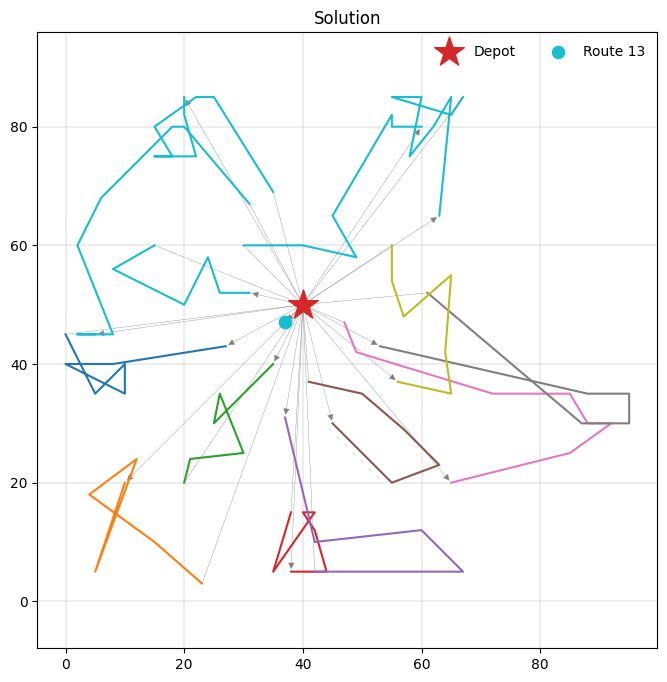

In [19]:
from pyvrp.plotting import plot_solution

_, ax = plt.subplots(figsize=(8, 8))
plot_solution(res.best, m.data(), ax=ax)

Next, let's verify the solution's validity within the MAEnvs4VRP environment.

In [20]:
all_inst = BenchmarkInstanceGenerator.get_list_of_benchmark_instances()
gen = BenchmarkInstanceGenerator(instance_type ='Solomon', set_of_instances=all_inst['Solomon'])
obs = Observations()
sel = AgentSelector()
rew = DenseReward()
env = Environment(instance_generator_object=gen,  
                obs_builder_object=obs,
                agent_selector_object=sel,
                reward_evaluator=rew,
                seed=0)

In [21]:
td = env.reset(num_agents=len(res.best.routes()), instance_name=instance_name, sample_type='not_random')
rewards = []
for idx, route in enumerate(res.best.routes(), 1):
    actions = route.visits() + [0]
    for action in actions:
        td['action'] = torch.tensor([[action]])
        td = env.step(td)
        rewards.append( td['reward'] + td['penalty'])

env.check_solution_validity()

print('distance: ', -torch.stack(rewards).sum(dim = 0).squeeze(-1).item())

distance:  1619.800048828125


In [22]:
print(f'env best time:, {-torch.stack(rewards).sum(dim = 0).squeeze(-1).item():.2f}')
print(f'solver best time:, {res.best.distance()/scale:.2f}, n agents: {len(res.best.routes())}')

env best time:, 1619.80
solver best time:, 1619.80, n agents: 15


As expected, we get the same value in both cases.

## Baseline values using PyVRP

Let's now use PyVRP to obtain baseline reference values for our validation instances, which are crucial for evaluating new neuro-solver algorithms.

In [23]:
val_set= 'servs_50_agents_25' 
instance_type='validation'

In [24]:
generator = InstanceGenerator()
set_of_instances = set(generator.get_list_of_benchmark_instances()[val_set][instance_type])
generator = InstanceGenerator(instance_type=instance_type, set_of_instances=set_of_instances)

In [25]:
obs = Observations()
sel = AgentSelector()
rew = DenseReward()
env = Environment(instance_generator_object=generator,  
                obs_builder_object=obs,
                agent_selector_object=sel,
                reward_evaluator=rew,
                seed=0)

In [26]:
total_times = []
total_nv = []
scale = 1_000
instance_name = generator.set_of_instances.pop()
print(instance_name)
    
inst_dict = generator.get_instance(instance_name)
n_digits = inst_dict.get('n_digits')
num_agents = inst_dict['num_agents']
batch_size = inst_dict['data'].batch_size[0]
for k in range(batch_size):
    instance = create_data_model(inst_dict['data'][k], n_digits=n_digits, scale=scale)
    
    res, _ = solver(instance)
    
    total_times.append(res.best.distance()/scale)
    total_nv.append(len(res.best.routes()))

print(f'av. time:, {np.mean(total_times)}, av agents: {np.mean(total_nv)}')

cvrptw/data/generated/servs_50_agents_25/validation/generated_val_servs_50_agents_25_27
PyVRP v0.11.3

Solving an instance with:
    1 depot
    50 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      2s |  34    13313    13093 |  35    13943    12874
     1000      4s |  41    13396    13093 |  56    13683    12935
     1500      6s |  51    13449    13093 |  45    13310    12813
     2000      9s |  56    13308    13093 |  36    13320    12924

Search terminated in 10.00s after 2331 iterations.
Best-found solution has cost 13093.

Solution results
    # routes: 9
     # trips: 9
   # clients: 50
   objective: 13093
    distance: 13093
    duration: 23183
# iterations: 2331
    run-time: 10.00 seconds

PyVRP v0.11.3

Solving an instance with:
    1 depot
    50 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeas

     2000      2s |  50     9436     8751 |  60     9031     8672
     2500      3s |  63     9354     8751 |  61     9060     8649
     3000      3s |  64     9341     8751 |  31     8711     8476
     3500      4s |  54     9445     8751 |  40     8898     8645
     4000      5s |  58     9445     8751 |  53     8929     8645
     4500      5s |  39     9522     8751 |  28     8832     8477
     5000      6s |  62     9263     8751 |  55     8804     8476
     5500      6s |  32     9673     8751 |  41     9055     8672
     6000      7s |  44     9536     8751 |  56     8809     8476
     6500      7s |  40     9632     8751 |  58     8984     8645
     7000      8s |  42     9576     8751 |  33     9101     8649
     7500      9s |  26     9802     8751 |  49     8799     8480
     8000      9s |  53     9406     8751 |  63     9045     8649
     8500     10s |  63     9334     8751 |  61     8815     8481

Search terminated in 10.00s after 8800 iterations.
Best-found solution has 

     4500      6s |  53    10991    10295 |  35    10019     9784
     5000      6s |  41    11054    10295 |  58    10077     9784
     5500      7s |  62    10896    10295 |  29    10255     9890
     6000      8s |  30    11286    10295 |  45     9759     8904
     6500      8s |  26    11393    10295 |  59    10148     9815
     7000      9s |  52    10988    10295 |  40    10051     9784
     7500     10s |  30    11199    10295 |  62    10082     9784

Search terminated in 10.00s after 7839 iterations.
Best-found solution has cost 10295.

Solution results
    # routes: 6
   # clients: 25
   objective: 10295
    distance: 10295
    duration: 15437
# iterations: 7839
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  36     7390     6660 |  41     6754     659

H     500      1s |  38    14311    13439 |  40    14411    13071
     1000      1s |  56    14166    13439 |  26    14088    12747
     1500      2s |  33    14386    13439 |  51    13601    13071
     2000      2s |  29    14494    13439 |  27    13928    13071
     2500      3s |  50    14138    13439 |  48    13431    12747
     3000      4s |  53    14124    13439 |  38    13882    13071
     3500      4s |  51    13655    13439 |  38    13166    12507
     4000      5s |  49    13685    13439 |  44    13303    12747
     4500      5s |  35    13692    13439 |  61    12492    11710
     5000      6s |  25    13644    13439 |  31    13360    12747
     5500      7s |  56    13598    13439 |  60    13561    13071
     6000      7s |  57    13598    13439 |  40    13663    13071
     6500      8s |  32    13609    13439 |  42    13667    13071
     7000      8s |  34    13633    13439 |  29    13917    13071
     7500      9s |  33    13666    13439 |  47    12782    12092
     8000 

 47%|█████████████████▊                    | 30/64 [2:40:09<3:01:30, 320.30s/it]


Search terminated in 10.00s after 8410 iterations.
Best-found solution has cost 13439.

Solution results
    # routes: 7
   # clients: 25
   objective: 13439
    distance: 13439
    duration: 18439
# iterations: 8410
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  31     8407     7727 |  49     7740     7371
     1000      1s |  54     8200     7727 |  55     7665     7371
     1500      2s |  43     8282     7727 |  50     7731     7470
     2000      2s |  49     8214     7727 |  41     7747     7470
     2500      3s |  47     8258     7727 |  47     7726     7470
     3000      3s |  50     8266     7727 |  34     7810     7470
     3500      4s |  58     8205     7727 |  43     7781     7470
     4000      4s |  47     8243     7727 |  26     7942     762

H     500      1s |  50    12011    11232 |  31    11291    10832
     1000      1s |  37    12198    11232 |  45    11560    11117
     1500      2s |  47    12064    11232 |  57    10639     9836
     2000      3s |  59    11966    11232 |  31    11402    11117
     2500      3s |  65    11870    11232 |  28    11337    11117
     3000      4s |  35    12229    11232 |  33    11151    10810
     3500      5s |  48    12061    11232 |  39    11582    11117
     4000      5s |  45    12073    11232 |  43    11260    10832
     4500      6s |  32    12205    11232 |  51    11160    10810
     5000      7s |  26    12400    11232 |  26    10459     9941
     5500      7s |  58    11980    11232 |  47    11374    10810
     6000      8s |  49    12027    11232 |  33    10431     9725
     6500      9s |  35    12221    11232 |  40    11097    10810
     7000      9s |  60    11982    11232 |  62    10481     9648

Search terminated in 10.00s after 7457 iterations.
Best-found solution has 

     4500      6s |  46    10462     9660 |  31     8832     8198
     5000      7s |  29    10857     9660 |  39     9736     9433
     5500      8s |  43    10552     9660 |  35     8719     8198
     6000      9s |  26    10980     9660 |  54     8719     8198
     6500      9s |  57    10383     9660 |  28     8770     8198

Search terminated in 10.00s after 6857 iterations.
Best-found solution has cost 9660.

Solution results
    # routes: 6
   # clients: 25
   objective: 9660
    distance: 9660
    duration: 14660
# iterations: 6857
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  25     8989     7869 |  60     7840     7529
     1000      1s |  25     9058     7869 |  34     7978     7529
     1500      2s |  51     8590     7869 |  52     8389     7825
 

H     500      1s |  27    10923    10025 |  62    10249     9801
     1000      1s |  52    10554    10025 |  30    10328     9897
H    1500      2s |  65    10530     9983 |  26     9838     9496
     2000      2s |  59    10538     9983 |  33    10140     9638
     2500      3s |  35    10836     9983 |  39     9753     9477
     3000      4s |  46    10622     9983 |  31    10262     9801
     3500      4s |  38    10718     9983 |  26    10126     9801
     4000      5s |  54    10582     9983 |  41    10101     9801
     4500      5s |  62    10536     9983 |  37     9514     8960
     5000      6s |  50    10587     9983 |  43    10123     9801
     5500      6s |  62    10506     9983 |  35    10122     9801
     6000      7s |  54    10565     9983 |  43    10215     9897
     6500      8s |  52    10579     9983 |  29    10221     9801
     7000      8s |  56    10543     9983 |  63    10039     9801
     7500      9s |  26    10993     9983 |  50    10125     9897
     8000 

     3000      3s |  58     7079     6628 |  50     6724     6533
     3500      4s |  53     7151     6628 |  39     6732     6533
     4000      4s |  27     7428     6628 |  35     6775     6533
     4500      5s |  61     7093     6628 |  65     6772     6533
     5000      5s |  46     7155     6628 |  51     6762     6533
     5500      6s |  40     7235     6628 |  26     6798     6533
     6000      6s |  64     7119     6628 |  34     6758     6533
     6500      7s |  48     7181     6628 |  26     6805     6533
     7000      7s |  42     7217     6628 |  59     6740     6533
     7500      8s |  65     7130     6628 |  41     6791     6533
     8000      8s |  50     7150     6628 |  36     6826     6533
     8500      9s |  37     7272     6628 |  41     6774     6533
     9000      9s |  40     7231     6628 |  26     6819     6533
     9500     10s |  60     7087     6628 |  36     6777     6533

Search terminated in 10.00s after 9728 iterations.
Best-found solution has 

     7000      9s |  60    12494    11662 |  46    11504    10884
     7500     10s |  33    12815    11662 |  59    11974    11079

Search terminated in 10.00s after 7865 iterations.
Best-found solution has cost 11662.

Solution results
    # routes: 6
   # clients: 25
   objective: 11662
    distance: 11662
    duration: 16662
# iterations: 7865
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  34     7781     7068 |  43     7152     6846
     1000      1s |  61     7567     7068 |  33     7254     6846
     1500      2s |  32     7895     7068 |  65     7127     6846
     2000      2s |  52     7634     7068 |  57     7187     6846
     2500      3s |  34     7946     7068 |  45     7274     6846
     3000      3s |  56     7603     7068 |  37     7210     684

 48%|██████████████████▍                   | 31/64 [2:45:29<2:56:09, 320.29s/it]

     9000     10s |  49    10354     9599 |  38     9875     9506

Search terminated in 10.00s after 9055 iterations.
Best-found solution has cost 9599.

Solution results
    # routes: 6
   # clients: 25
   objective: 9599
    distance: 9599
    duration: 14599
# iterations: 9055
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  39     8073     7481 |  42     7590     7461
     1000      1s |  31     8171     7481 |  35     7638     7461
     1500      2s |  62     7993     7481 |  35     7616     7461
     2000      2s |  61     7943     7481 |  64     7546     7461
     2500      3s |  25     8270     7481 |  61     7589     7461
     3000      3s |  65     7938     7481 |  50     7599     7461
     3500      4s |  65     7973     7481 |  56     7608     7461
 

H     500      1s |  51     7134     6756 |  51     6701     6393
     1000      1s |  31     7317     6756 |  29     6644     6393
     1500      2s |  45     7183     6756 |  60     6660     6393
     2000      2s |  28     7376     6756 |  41     6678     6393
     2500      3s |  61     7086     6756 |  31     6657     6393
     3000      3s |  50     7147     6756 |  25     6660     6393
     3500      4s |  35     7265     6756 |  49     6649     6393
     4000      4s |  56     7116     6756 |  54     6650     6393
     4500      5s |  42     7206     6756 |  43     6645     6393
     5000      5s |  50     7163     6756 |  35     6654     6393
     5500      6s |  44     7201     6756 |  35     6658     6393
     6000      6s |  59     7112     6756 |  25     6681     6393
     6500      7s |  30     7367     6756 |  45     6685     6393
     7000      8s |  55     7149     6756 |  64     6606     6393
     7500      8s |  44     6932     6756 |  57     6642     6393
     8000 

H     500      1s |  59     8889     8356 |  33     8445     8230
     1000      1s |  40     9053     8356 |  27     8501     8230
     1500      2s |  30     9177     8356 |  43     8399     8230
     2000      2s |  62     8838     8356 |  36     8226     8049
     2500      3s |  53     8899     8356 |  46     8725     8230
     3000      4s |  39     9056     8356 |  28     8554     8230
     3500      4s |  38     9108     8356 |  49     8235     8042
     4000      5s |  42     9013     8356 |  49     8197     8042
     4500      6s |  40     8997     8356 |  26     8613     8230
     5000      6s |  31     9117     8356 |  36     8220     8049
     5500      7s |  33     9115     8356 |  60     9042     8230
     6000      7s |  25     9352     8356 |  53     8224     8049
     6500      8s |  60     8857     8356 |  25     8300     8052
     7000      9s |  37     9032     8356 |  44     8798     8230
     7500      9s |  36     9106     8356 |  39     8210     8042
     8000 

     4000      5s |  30    10142     9173 |  51     9329     8843
     4500      6s |  56     9757     9173 |  29     9305     8843
     5000      7s |  30    10090     9173 |  56     8894     8350
     5500      7s |  32    10108     9173 |  40     9466     8908
     6000      8s |  63     9689     9173 |  62     9341     8843
     6500      9s |  44     9932     9173 |  46     8731     8304
     7000      9s |  59     9826     9173 |  28     8770     8304

Search terminated in 10.00s after 7426 iterations.
Best-found solution has cost 9173.

Solution results
    # routes: 6
   # clients: 25
   objective: 9173
    distance: 9173
    duration: 14173
# iterations: 7426
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  41     9708     9498 |  62     9574     9346
 

H     500      1s |  37    12252    11409 |  44    11639    10961
     1000      1s |  43    11658    11409 |  28    12431    11385
     1500      2s |  59    11745    11409 |  44    11414    10961
     2000      3s |  37    11623    11409 |  52    10738    10114
     2500      3s |  62    11660    11409 |  31    11347    10961
     3000      4s |  30    11650    11409 |  62    11006    10228
     3500      5s |  46    11618    11409 |  65    11973    11030
     4000      5s |  55    11737    11409 |  41    11277    10961
     4500      6s |  31    11558    11409 |  56    11582    11325
     5000      7s |  56    11656    11409 |  55    10860    10187
     5500      8s |  44    11738    11409 |  65    10472     9981
     6000      8s |  56    11626    11409 |  35    11628    11325
     6500      9s |  38    11613    11409 |  65    11319    10961
     7000     10s |  49    11679    11409 |  52    11316    10961

Search terminated in 10.00s after 7267 iterations.
Best-found solution has 

     8000      9s |  43    10123     9185 |  34     9514     9215
     8500     10s |  59     9952     9185 |  47     9282     8882

Search terminated in 10.00s after 8503 iterations.
Best-found solution has cost 9185.

Solution results
    # routes: 6
   # clients: 25
   objective: 9185
    distance: 9185
    duration: 14185
# iterations: 8503
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  45     7815     6997 |  25     6925     6579
     1000      1s |  64     7660     6997 |  54     6885     6579
     1500      2s |  27     8038     6997 |  64     7264     6927
     2000      2s |  38     7873     6997 |  26     7042     6579
     2500      3s |  45     7786     6997 |  62     7212     6927
     3000      3s |  47     7758     6997 |  64     6930     6579
 

 50%|███████████████████                   | 32/64 [2:50:50<2:50:49, 320.29s/it]


Search terminated in 10.00s after 8817 iterations.
Best-found solution has cost 7573.

Solution results
    # routes: 5
   # clients: 25
   objective: 7573
    distance: 7573
    duration: 13194
# iterations: 8817
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  27    10244     9299 |  25     8894     8511
     1000      1s |  54     9897     9299 |  50     9352     8984
     1500      2s |  46     9962     9299 |  53     9241     8928
     2000      2s |  49     9932     9299 |  65     9323     8928
     2500      3s |  42    10003     9299 |  45     9037     8511
     3000      4s |  45     9971     9299 |  62     9472     8987
     3500      4s |  52     9859     9299 |  38     9246     8928
     4000      5s |  31    10127     9299 |  31     9232     8928
 

H     500      1s |  43    12644    11910 |  48    11441    10989
     1000      1s |  26    12845    11910 |  59    10186     9556
     1500      2s |  58    12414    11910 |  64    11755    11320
     2000      3s |  40    12596    11910 |  47     9919     9556
     2500      4s |  47    12555    11910 |  40    11800    11320
     3000      4s |  39    12610    11910 |  56    11984    11410
     3500      5s |  41    12624    11910 |  48    11855    11320
     4000      6s |  46    12578    11910 |  59    11413    10989
     4500      6s |  64    12441    11910 |  57    10079     9556
     5000      7s |  28    12872    11910 |  28    11952    11320
     5500      8s |  34    12698    11910 |  30    12323    11705
     6000      8s |  35    12662    11910 |  58    11843    11320
     6500      9s |  36    12631    11910 |  46    11856    11320
     7000     10s |  37    12674    11910 |  49    10119     9556

Search terminated in 10.00s after 7093 iterations.
Best-found solution has 

     3500      4s |  26     9895     8868 |  61     9338     8554
     4000      5s |  51     9646     8868 |  29     8339     7379
     4500      6s |  43     9653     8868 |  56     9014     8554
     5000      6s |  40     9666     8868 |  55     8760     7666
     5500      7s |  42     9644     8868 |  35     9170     8612
     6000      8s |  52     9537     8868 |  43     9080     8612
     6500      8s |  64     9478     8868 |  59     9236     8612
     7000      9s |  58     9477     8868 |  39     9211     8555
     7500      9s |  40     9757     8868 |  40     8021     7379

Search terminated in 10.00s after 7935 iterations.
Best-found solution has cost 8868.

Solution results
    # routes: 5
   # clients: 25
   objective: 8868
    distance: 8868
    duration: 13881
# iterations: 7935
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
 

     7500      8s |  34     8252     7611 |  59     7519     7252
     8000      9s |  33     8260     7611 |  57     7542     7252
     8500      9s |  38     8241     7611 |  62     7540     7252
     9000     10s |  51     8098     7611 |  29     7662     7252

Search terminated in 10.00s after 9073 iterations.
Best-found solution has cost 7611.

Solution results
    # routes: 6
   # clients: 25
   objective: 7611
    distance: 7611
    duration: 12997
# iterations: 9073
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  52     9572     8950 |  63     8747     8347
     1000      1s |  41     9775     8950 |  44     8851     8347
     1500      2s |  31    10115     8950 |  62     9259     8932
     2000      2s |  41     9862     8950 |  40     9258     8932
 

H     500      1s |  27     9194     8073 |  27     8412     8162
     1000      1s |  41     8896     8073 |  36     8032     7674
     1500      2s |  53     8816     8073 |  61     8014     7674
     2000      2s |  25     9262     8073 |  54     8569     8097
     2500      3s |  51     8806     8073 |  65     8532     8046
     3000      4s |  59     8772     8073 |  29     8050     7674
     3500      4s |  63     8745     8073 |  58     8075     7674
     4000      5s |  29     9164     8073 |  45     8034     7674
     4500      5s |  48     8854     8073 |  54     8014     7674
     5000      6s |  59     8796     8073 |  36     8053     7674
     5500      7s |  34     9062     8073 |  37     8034     7674
     6000      7s |  32     9100     8073 |  57     8609     8046
     6500      8s |  33     9098     8073 |  62     7995     7674
     7000      8s |  51     8795     8073 |  57     8055     7674
     7500      9s |  54     8743     8073 |  56     8025     7674
     8000 

     5500      6s |  35    10244     9292 |  32     9629     9324
     6000      7s |  38    10172     9292 |  46     9553     9360
     6500      8s |  48     9976     9292 |  60     9793     9414
     7000      8s |  45    10074     9292 |  39     8924     8468
     7500      9s |  33    10241     9292 |  35     8813     8468
     8000     10s |  38    10089     9292 |  51     9491     9305

Search terminated in 10.00s after 8404 iterations.
Best-found solution has cost 9292.

Solution results
    # routes: 6
   # clients: 25
   objective: 9292
    distance: 9292
    duration: 14667
# iterations: 8404
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  34     8610     7751 |  34     7580     7231
     1000      1s |  47     8462     7751 |  51     7561     7141
 

 52%|███████████████████▌                  | 33/64 [2:56:10<2:45:28, 320.28s/it]


Search terminated in 10.00s after 8445 iterations.
Best-found solution has cost 8868.

Solution results
    # routes: 6
   # clients: 25
   objective: 8868
    distance: 8868
    duration: 13868
# iterations: 8445
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  33    10164     9255 |  26     9270     8948
     1000      1s |  40    10037     9255 |  35     9336     8948
     1500      2s |  51     9939     9255 |  64     9292     8948
     2000      3s |  64     9885     9255 |  40     9274     8948
     2500      3s |  28    10317     9255 |  57     9263     8948
     3000      4s |  26    10351     9255 |  54     9303     8948
     3500      4s |  51     9987     9255 |  48     9545     9103
     4000      5s |  51     9925     9255 |  28     9316     8948
 

H     500      1s |  32     7527     6693 |  48     6608     6443
     1000      1s |  59     7261     6693 |  65     6680     6443
     1500      2s |  56     7233     6693 |  35     6733     6443
     2000      2s |  43     7344     6693 |  64     6629     6443
     2500      3s |  35     7477     6693 |  50     6685     6443
     3000      4s |  29     7530     6693 |  32     6729     6443
     3500      4s |  52     7277     6693 |  35     6700     6443
     4000      5s |  43     7343     6693 |  53     6668     6443
     4500      5s |  33     7470     6693 |  63     6675     6443
     5000      6s |  54     7282     6693 |  42     6689     6443
     5500      7s |  46     7331     6693 |  55     6664     6443
     6000      7s |  53     7218     6693 |  60     6639     6443
     6500      8s |  33     7472     6693 |  34     6710     6443
     7000      8s |  65     7201     6693 |  36     6715     6443
     7500      9s |  59     7198     6693 |  59     6645     6443
     8000 

     2500      3s |  39     8707     8160 |  60     8131     7960
     3000      3s |  26     8927     8160 |  59     8174     7960
     3500      4s |  28     8871     8160 |  61     8233     7976
     4000      4s |  28     8893     8160 |  58     8212     7976
     4500      5s |  46     8672     8160 |  59     8172     7976
     5000      5s |  48     8657     8160 |  54     8201     7976
     5500      6s |  43     8715     8160 |  45     8252     8000
     6000      6s |  27     8917     8160 |  46     8233     8000
     6500      7s |  54     8650     8160 |  43     8252     8000
     7000      8s |  58     8566     8160 |  43     8150     7944
     7500      8s |  25     8979     8160 |  51     8129     7944
     8000      9s |  29     8882     8160 |  56     8118     7960
     8500      9s |  62     8541     8160 |  60     8141     7944
     9000     10s |  25     8986     8160 |  27     8251     7944

Search terminated in 10.00s after 9244 iterations.
Best-found solution has 

     6500      7s |  53    10633     9870 |  54    10001     9655
     7000      7s |  46    10653     9870 |  34    10073     9683
     7500      8s |  35    10814     9870 |  32    10182     9699
     8000      8s |  63    10564     9870 |  36    10056     9655
     8500      9s |  26    10982     9870 |  44    10025     9699
     9000      9s |  39    10708     9870 |  51    10024     9683
     9500     10s |  46    10629     9870 |  39    10022     9683

Search terminated in 10.00s after 9934 iterations.
Best-found solution has cost 9870.

Solution results
    # routes: 6
   # clients: 25
   objective: 9870
    distance: 9870
    duration: 14870
# iterations: 9934
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  63     9564     9051 |  33     9109     8640
 

H     500      1s |  50    15058    14124 |  62    15309    14056
     1000      1s |  61    14947    14124 |  61    14674    14056
     1500      2s |  53    14907    14124 |  38    14385    14056
     2000      2s |  39    15066    14124 |  49    14573    14056
     2500      3s |  43    15008    14124 |  47    14623    14056
     3000      4s |  41    15113    14124 |  65    15059    14056
     3500      4s |  53    15044    14124 |  34    15066    14056
     4000      5s |  52    14999    14124 |  35    14500    14056
     4500      6s |  52    14946    14124 |  41    14510    14056
     5000      6s |  30    15376    14124 |  43    14343    13705
     5500      7s |  38    15168    14124 |  38    14806    14056
     6000      8s |  52    15058    14124 |  46    14416    14056
     6500      8s |  55    15138    14124 |  48    14544    13667
     7000      9s |  29    15285    14124 |  53    14375    14056
     7500     10s |  34    15192    14124 |  57    14424    14104

Search te

     5500      7s |  48    10924    10242 |  35    10096     9813
     6000      8s |  64    10747    10242 |  52    10068     9693
     6500      8s |  34    11039    10242 |  35    10008     9693
     7000      9s |  39    10437    10242 |  58    10136     9693
     7500      9s |  32    10442    10242 |  40    10236     9693

Search terminated in 10.00s after 7977 iterations.
Best-found solution has cost 10242.

Solution results
    # routes: 6
   # clients: 25
   objective: 10242
    distance: 10242
    duration: 15242
# iterations: 7977
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  46     7963     7265 |  50     7356     7153
     1000      1s |  31     8322     7265 |  52     7415     7153
     1500      2s |  59     7861     7265 |  45     7441     715

 53%|████████████████████▏                 | 34/64 [3:01:30<2:40:08, 320.28s/it]


Search terminated in 10.00s after 8967 iterations.
Best-found solution has cost 7048.

Solution results
    # routes: 5
   # clients: 25
   objective: 7048
    distance: 7048
    duration: 12876
# iterations: 8967
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  52     7739     7229 |  38     6955     6697
     1000      1s |  30     7935     7229 |  61     7156     6906
     1500      2s |  36     7826     7229 |  59     7146     6906
     2000      2s |  53     7727     7229 |  60     7181     6908
     2500      3s |  31     7928     7229 |  59     7153     6906
     3000      4s |  46     7763     7229 |  49     6978     6697
     3500      4s |  41     7796     7229 |  44     7136     6906
     4000      5s |  51     7758     7229 |  31     7164     6906
 

H     500      1s |  29    10371     9150 |  38     9953     9270
     1000      1s |  64     9925     9150 |  44     9032     8677
     1500      2s |  57     9582     9150 |  42     9131     8677
     2000      3s |  50     9664     9150 |  46     9028     8677
     2500      4s |  38     9535     9150 |  48     9610     9149
     3000      4s |  45     9671     9150 |  35     9105     8677
     3500      5s |  25     9648     9150 |  43     9089     8677
     4000      6s |  56     9587     9150 |  39     9063     8677
     4500      6s |  26     9584     9150 |  25     9110     8677
     5000      7s |  62     9552     9150 |  59     9117     8677
     5500      8s |  40     9569     9150 |  61     8997     8677
     6000      9s |  32     9668     9150 |  28     9051     8677
     6500      9s |  27     9628     9150 |  65     9056     8677
     7000     10s |  55     9622     9150 |  65     9054     8677

Search terminated in 10.00s after 7068 iterations.
Best-found solution has 

     7000      9s |  62     8988     8476 |  44     8178     7876

Search terminated in 10.00s after 7444 iterations.
Best-found solution has cost 8476.

Solution results
    # routes: 6
   # clients: 25
   objective: 8476
    distance: 8476
    duration: 13476
# iterations: 7444
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  41     9496     8848 |  42     8491     8200
     1000      1s |  25     9801     8848 |  40     8697     8374
     1500      2s |  33     9645     8848 |  38     8746     8374
     2000      3s |  62     9386     8848 |  49     8333     7880
     2500      3s |  38     9556     8848 |  44     8676     8374
     3000      4s |  36     9652     8848 |  54     8930     8374
     3500      4s |  65     9344     8848 |  50     8462     8006
 

H     500      1s |  64    10425     9691 |  27     9606     9179
     1000      1s |  26    10699     9691 |  38    10229     9839
     1500      2s |  54    10434     9691 |  42     9769     9453
     2000      3s |  51    10426     9691 |  56     9547     9179
     2500      3s |  27    10644     9691 |  31     9556     9179
     3000      4s |  63    10381     9691 |  40     9616     8754
     3500      5s |  48    10451     9691 |  51     9550     9179
     4000      5s |  55    10358     9691 |  56    10254     9826
     4500      6s |  36    10583     9691 |  33     9124     8376
     5000      7s |  45    10505     9691 |  36     9885     9179
     5500      7s |  37    10502     9691 |  55     9415     8643
     6000      8s |  28    10647     9691 |  58     9895     9453
     6500      9s |  60    10266     9691 |  43     9603     8754
     7000      9s |  37    10459     9691 |  55     9686     9179

Search terminated in 10.00s after 7415 iterations.
Best-found solution has 

     5000      5s |  58     8100     7703 |  36     7780     7483
     5500      6s |  64     8064     7703 |  31     7782     7483
     6000      6s |  40     8250     7703 |  58     7693     7483
     6500      7s |  45     8216     7703 |  38     7739     7483
     7000      7s |  39     8285     7703 |  65     7720     7483
     7500      8s |  55     8131     7703 |  52     7743     7483
     8000      9s |  61     8105     7703 |  44     7753     7483
     8500      9s |  63     8073     7703 |  31     7770     7483
     9000     10s |  26     8546     7703 |  61     7716     7483

Search terminated in 10.00s after 9259 iterations.
Best-found solution has cost 7703.

Solution results
    # routes: 6
   # clients: 25
   objective: 7703
    distance: 7703
    duration: 12703
# iterations: 9259
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
 

H     500      1s |  36     8834     8068 |  49     8398     8080
     1000      1s |  48     8782     8068 |  40     8111     7919
     1500      2s |  56     8765     8068 |  38     8124     7919
     2000      3s |  46     8740     8068 |  62     8091     7919
     2500      3s |  55     8687     8068 |  36     8103     7919
     3000      4s |  39     8831     8068 |  62     8071     7919
     3500      4s |  52     8769     8068 |  49     8146     7919
     4000      5s |  38     8876     8068 |  45     8099     7919
     4500      6s |  25     9063     8068 |  31     8112     7919
     5000      6s |  60     8725     8068 |  63     8150     7919
     5500      7s |  50     8756     8068 |  54     8090     7919
     6000      7s |  41     8831     8068 |  30     8157     7919
     6500      8s |  25     9037     8068 |  44     8148     7919
     7000      9s |  53     8695     8068 |  29     8128     7919
     7500      9s |  32     8902     8068 |  51     8138     7919
     8000 

 55%|████████████████████▊                 | 35/64 [3:06:51<2:34:48, 320.28s/it]


Search terminated in 10.00s after 8299 iterations.
Best-found solution has cost 7757.

Solution results
    # routes: 6
   # clients: 25
   objective: 7757
    distance: 7757
    duration: 13029
# iterations: 8299
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  33     7285     6841 |  49     6786     6751
     1000      1s |  35     7305     6841 |  32     7121     6826
     1500      2s |  65     7238     6841 |  63     7029     6801
     2000      2s |  56     7360     6841 |  43     7313     6826
     2500      3s |  40     7639     6841 |  49     7300     6826
     3000      3s |  60     7419     6841 |  51     7223     6811
     3500      4s |  49     7634     6841 |  57     7129     6801
     4000      4s |  37     7800     6841 |  32     7299     6801
 

H     500      1s |  60     8222     7608 |  50     7898     7524
     1000      1s |  44     8387     7608 |  27     8172     7541
     1500      2s |  43     8473     7608 |  42     8072     7541
     2000      2s |  64     8283     7608 |  54     7981     7541
     2500      3s |  41     8364     7608 |  59     7911     7524
     3000      3s |  41     8402     7608 |  31     7801     7481
     3500      4s |  59     8277     7608 |  40     7954     7524
     4000      5s |  62     8251     7608 |  51     7935     7524
     4500      5s |  36     8432     7608 |  56     7753     7481
     5000      6s |  46     8380     7608 |  29     8169     7541
     5500      6s |  41     8399     7608 |  36     7786     7481
     6000      7s |  46     8322     7608 |  52     7766     7481
     6500      8s |  48     8317     7608 |  26     8098     7541
     7000      8s |  46     8341     7608 |  44     7988     7541
     7500      9s |  58     8197     7608 |  61     7829     7524
     8000 

     1500      2s |  50    12065    10942 |  55    10687     9867
     2000      3s |  26    12573    10942 |  27    11274    10798
     2500      3s |  57    11967    10942 |  27    10583    10164
     3000      4s |  63    12014    10942 |  33    11319    10798
     3500      5s |  27    12436    10942 |  47    11241    10798
     4000      5s |  65    11810    10942 |  48    10860     9867
     4500      6s |  54    11989    10942 |  29    11363    10798
     5000      7s |  46    12108    10942 |  43    11832    10798
     5500      8s |  35    12272    10942 |  50    11828    11035
     6000      8s |  26    12560    10942 |  57    11948    10964
     6500      9s |  53    11982    10942 |  57    11248    10798
     7000     10s |  36    12338    10942 |  48    11298    10798

Search terminated in 10.00s after 7208 iterations.
Best-found solution has cost 10942.

Solution results
    # routes: 6
   # clients: 25
   objective: 10942
    distance: 10942
    duration: 15942
# iterati

     5000      6s |  64     8804     8442 |  43     8666     8291
     5500      7s |  46     9002     8442 |  64     8610     8291
     6000      7s |  48     8926     8442 |  48     8636     8291
     6500      8s |  39     8975     8442 |  39     8657     8291
     7000      8s |  36     9037     8442 |  26     8893     8291
     7500      9s |  37     9063     8442 |  56     8596     8241
     8000      9s |  42     8953     8442 |  44     8695     8291
     8500     10s |  62     8862     8442 |  28     8811     8291

Search terminated in 10.00s after 8503 iterations.
Best-found solution has cost 8442.

Solution results
    # routes: 6
   # clients: 25
   objective: 8442
    distance: 8442
    duration: 13532
# iterations: 8503
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H

     8000      9s |  35     8026     7456 |  39     7673     7453
     8500      9s |  34     8034     7456 |  45     7732     7453
     9000     10s |  43     7945     7456 |  45     7645     7453

Search terminated in 10.00s after 9011 iterations.
Best-found solution has cost 7456.

Solution results
    # routes: 5
   # clients: 25
   objective: 7456
    distance: 7456
    duration: 12884
# iterations: 9011
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  65    11730    11050 |  38    10886    10392
     1000      1s |  38    11898    11050 |  38    10947     9584
     1500      2s |  31    12051    11050 |  52    10939    10392
     2000      3s |  64    11767    11050 |  27    11047    10392
     2500      3s |  37    12014    11050 |  56    11187    10392
 

H     500      1s |  27     9233     8317 |  26     8508     8248
     1000      1s |  43     8943     8317 |  64     8651     8334
     1500      2s |  63     8844     8317 |  52     8538     8097
     2000      2s |  50     8874     8317 |  50     8484     8248
     2500      3s |  28     9188     8317 |  30     8252     7820
     3000      4s |  30     9169     8317 |  35     8454     8178
     3500      4s |  49     8853     8317 |  56     8622     8340
     4000      5s |  53     8892     8317 |  63     8484     8097
     4500      5s |  29     9146     8317 |  31     8635     8248
     5000      6s |  50     8804     8317 |  40     8640     8340
     5500      7s |  38     8950     8317 |  51     8661     8340
     6000      7s |  36     9006     8317 |  25     8461     8178
     6500      8s |  43     8914     8317 |  36     8474     8248
     7000      8s |  56     8840     8317 |  30     8438     8097
     7500      9s |  50     8873     8317 |  29     8437     8097
     8000 

     2500      3s |  58     8708     7967 |  32     8278     7957
     3000      3s |  34     9210     7967 |  54     8244     7957
     3500      4s |  35     9139     7967 |  62     8321     8000
     4000      4s |  63     8755     7967 |  49     8268     7957
     4500      5s |  62     8753     7967 |  56     8296     7957
     5000      5s |  50     8862     7967 |  48     8235     7957
     5500      6s |  27     9522     7967 |  37     8258     7930
     6000      6s |  31     9296     7967 |  27     8200     7930
     6500      7s |  40     9027     7967 |  57     8239     7957
     7000      7s |  43     8978     7967 |  52     8216     7957
     7500      8s |  55     8730     7967 |  46     8117     7930
     8000      8s |  48     8870     7967 |  25     8219     7930
     8500      9s |  48     8895     7967 |  60     8223     7957
     9000     10s |  28     9438     7967 |  64     8265     8000


 56%|█████████████████████▍                | 36/64 [3:12:11<2:29:28, 320.32s/it]


Search terminated in 10.00s after 9430 iterations.
Best-found solution has cost 7967.

Solution results
    # routes: 5
   # clients: 25
   objective: 7967
    distance: 7967
    duration: 12967
# iterations: 9430
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  40    10066     9067 |  31     9689     9034
     1000      1s |  58     9778     9067 |  47     9428     9034
     1500      2s |  51     9843     9067 |  39     9669     9034
     2000      2s |  35    10082     9067 |  63     9500     9034
     2500      3s |  36    10108     9067 |  64     9490     8836
     3000      3s |  58     9869     9067 |  45     9139     8347
     3500      4s |  29    10306     9067 |  38     9350     9010
     4000      5s |  64     9748     9067 |  57     9433     9010
 

H     500      1s |  48     9964     9323 |  61     9383     9159
     1000      1s |  65     9838     9323 |  40     9417     9159
     1500      2s |  53     9942     9323 |  53     9458     9159
     2000      2s |  46    10026     9323 |  64     9392     9162
     2500      3s |  63     9820     9323 |  63     9473     9166
     3000      3s |  45     9971     9323 |  47     9604     9166
     3500      4s |  35    10050     9323 |  31     9551     9166
     4000      4s |  33    10152     9323 |  31     9555     9166
     4500      5s |  53     9866     9323 |  63     9325     8977
     5000      5s |  35    10125     9323 |  48     9614     9171
     5500      6s |  49     9903     9323 |  52     9450     9166
     6000      6s |  34    10103     9323 |  33     9583     9171
     6500      7s |  32    10190     9323 |  64     9466     9162
     7000      7s |  48     9945     9323 |  62     9464     9166
     7500      8s |  42     9990     9323 |  49     9420     9159
     8000 

     3500      4s |  30    11881    10797 |  37    11075    10499
     4000      5s |  41    11646    10797 |  52    10872    10323
     4500      6s |  59    11503    10797 |  37    11013    10499
     5000      6s |  42    11670    10797 |  60    11095    10323
     5500      7s |  28    11957    10797 |  40    10989    10323
     6000      8s |  44    11665    10797 |  29    10495    10035
     6500      8s |  40    11662    10797 |  61    10768    10357
     7000      9s |  53    11532    10797 |  35    11002    10323
     7500     10s |  34    11120    10797 |  43    10853    10323

Search terminated in 10.00s after 7740 iterations.
Best-found solution has cost 10797.

Solution results
    # routes: 6
   # clients: 25
   objective: 10797
    distance: 10797
    duration: 15797
# iterations: 7740
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasibl

H     500      1s |  42     7922     7379 |  54     7341     7134
     1000      1s |  51     7865     7379 |  44     7335     7134
     1500      2s |  61     7780     7379 |  62     7668     7329
     2000      2s |  42     7906     7379 |  29     7628     7329
     2500      3s |  29     8146     7379 |  51     7352     7134
     3000      4s |  47     7853     7379 |  52     7344     7134
     3500      4s |  65     7757     7379 |  48     7357     7134
     4000      5s |  43     7925     7379 |  30     7408     7134
     4500      5s |  50     7895     7379 |  58     7552     7329
     5000      6s |  35     8070     7379 |  59     7360     7134
     5500      7s |  27     8179     7379 |  55     7589     7329
     6000      7s |  28     8190     7379 |  55     7340     7134
     6500      8s |  34     8059     7379 |  54     7413     7199
     7000      9s |  43     7957     7379 |  53     7333     7134
     7500      9s |  50     7884     7379 |  27     7423     7134
     8000 

     4000      6s |  64    11197    10397 |  52    10253     9702
     4500      7s |  49    11107    10397 |  61    10743    10056
     5000      8s |  50    11209    10397 |  49    10712     9869
     5500      9s |  40    10651    10397 |  46    10235     9806
     6000      9s |  60    10692    10397 |  37    10226     9806
     6500     10s |  55    10737    10397 |  52    11094    10056

Search terminated in 10.00s after 6532 iterations.
Best-found solution has cost 10397.

Solution results
    # routes: 6
   # clients: 25
   objective: 10397
    distance: 10397
    duration: 15614
# iterations: 6532
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  25     8003     6929 |  53     7106     6595
     1000      1s |  52     7602     6929 |  60     6931     655

     8000      9s |  55     7637     7183 |  45     7217     7076
     8500     10s |  58     7573     7183 |  46     7206     7076

Search terminated in 10.00s after 8709 iterations.
Best-found solution has cost 7183.

Solution results
    # routes: 6
   # clients: 25
   objective: 7183
    distance: 7183
    duration: 12541
# iterations: 8709
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  55    10764    10042 |  43    10351     9658
     1000      1s |  50    10787    10042 |  57     9444     9140
     1500      2s |  41    10866    10042 |  53     9677     9140
     2000      2s |  34    10965    10042 |  64    10354     9658
     2500      3s |  32    11076    10042 |  31    10144     9479
     3000      4s |  65    10696    10042 |  37    10473     9658
 

 58%|█████████████████████▉                | 37/64 [3:17:31<2:24:08, 320.30s/it]


Search terminated in 10.00s after 8732 iterations.
Best-found solution has cost 7008.

Solution results
    # routes: 5
   # clients: 25
   objective: 7008
    distance: 7008
    duration: 12008
# iterations: 8732
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  59    10337     9749 |  29     9330     8971
     1000      1s |  29    10650     9749 |  26    10132     9661
     1500      2s |  40    10041     9749 |  29     9229     8959
     2000      3s |  36    10072     9749 |  65     9360     8959
     2500      4s |  45    10080     9749 |  32     9209     8959
     3000      5s |  60    10143     9749 |  40     9162     8959
     3500      5s |  65    10002     9749 |  32     9311     8971
     4000      6s |  62    10121     9749 |  40     9201     8959
 

     3500      5s |  41     8162     7568 |  32     7232     7063
     4000      6s |  26     8426     7568 |  62     7245     7063
     4500      6s |  46     8134     7568 |  50     7256     7063
     5000      7s |  42     8172     7568 |  41     7266     7063
     5500      8s |  55     8014     7568 |  28     7252     7063
     6000      8s |  46     8085     7568 |  60     7267     7063
     6500      9s |  64     8009     7568 |  58     7287     7063
     7000     10s |  51     8062     7568 |  48     7299     7063

Search terminated in 10.00s after 7246 iterations.
Best-found solution has cost 7568.

Solution results
    # routes: 6
   # clients: 25
   objective: 7568
    distance: 7568
    duration: 13054
# iterations: 7246
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H

     7500      8s |  60     7460     7041 |  39     6939     6792
     8000      9s |  40     7620     7041 |  52     7161     6897
     8500     10s |  59     7456     7041 |  59     6944     6792

Search terminated in 10.00s after 8814 iterations.
Best-found solution has cost 7041.

Solution results
    # routes: 6
   # clients: 25
   objective: 7041
    distance: 7041
    duration: 12098
# iterations: 8814
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  28    10568     9574 |  47     9662     9387
     1000      1s |  55    10216     9574 |  52     9755     9427
     1500      2s |  27    10609     9574 |  64     9716     9427
     2000      2s |  38    10408     9574 |  57     9728     9387
     2500      3s |  31    10472     9574 |  43     9857     9427
 

H     500      1s |  27     9897     8785 |  36     8460     8130
     1000      1s |  34     9807     8785 |  27     8452     8130
     1500      2s |  26     9927     8785 |  49     8623     8130
     2000      3s |  58     9531     8785 |  28     8475     8130
     2500      4s |  40     9636     8785 |  62     8434     8130
     3000      4s |  54     9521     8785 |  30     9274     8818
     3500      5s |  65     9484     8785 |  60     8418     8130
     4000      6s |  65     9406     8785 |  28     9179     8818
     4500      6s |  40     9635     8785 |  37     8521     8130
     5000      7s |  63     9490     8785 |  59     8492     8130
     5500      8s |  31     9768     8785 |  51     8491     8130
     6000      8s |  50     9547     8785 |  53     8460     8130
     6500      9s |  49     9585     8785 |  38     8453     8130
     7000     10s |  39     9667     8785 |  52     8411     8130

Search terminated in 10.00s after 7016 iterations.
Best-found solution has 

     4500      5s |  34    12050    10999 |  35    11500    10973
     5000      6s |  25    12294    10999 |  46    11585    10973
     5500      7s |  59    11765    10999 |  27    10926    10246
     6000      7s |  58    11676    10999 |  65    11261    10961
     6500      8s |  54    11834    10999 |  58    10967    10246
     7000      9s |  52    11770    10999 |  54    11373    10961
     7500      9s |  32    11999    10999 |  50    11281    10961
     8000     10s |  37    11939    10999 |  62    11244    10961

Search terminated in 10.00s after 8041 iterations.
Best-found solution has cost 10999.

Solution results
    # routes: 6
   # clients: 25
   objective: 10999
    distance: 10999
    duration: 15999
# iterations: 8041
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Bes

     6500      7s |  42    11468    10503 |  54    10722    10227
     7000      7s |  29    11664    10503 |  55    10474    10147
     7500      8s |  28    11647    10503 |  54    10696    10243
     8000      9s |  27    11749    10503 |  37    10620    10215
     8500      9s |  61    11308    10503 |  61    10742    10243
     9000     10s |  25    11791    10503 |  42    10474    10051

Search terminated in 10.00s after 9352 iterations.
Best-found solution has cost 10503.

Solution results
    # routes: 6
   # clients: 25
   objective: 10503
    distance: 10503
    duration: 15503
# iterations: 9352
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  42    11435    10645 |  54    10766    10354
H    1000      1s |  32    11565    10564 |  37    10622    1017

 59%|██████████████████████▌               | 38/64 [3:22:51<2:18:47, 320.29s/it]


Search terminated in 10.00s after 9459 iterations.
Best-found solution has cost 6608.

Solution results
    # routes: 5
   # clients: 25
   objective: 6608
    distance: 6608
    duration: 11667
# iterations: 9459
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  60    10980    10329 |  38     9882     9510
     1000      1s |  32    11219    10329 |  65    10639    10099
     1500      2s |  63    10977    10329 |  29    10475    10099
     2000      3s |  33    11265    10329 |  63    10511    10099
     2500      3s |  51    11085    10329 |  43    10594    10126
     3000      4s |  65    10922    10329 |  63    10682    10220
     3500      5s |  60    10987    10329 |  53    10688    10220
     4000      5s |  39    11174    10329 |  28    10626    10126
 

     1500      2s |  46    10080     9356 |  29     9522     8994
     2000      2s |  63     9809     9356 |  62     9519     9099
     2500      3s |  51     9908     9356 |  41     9551     9099
     3000      3s |  48     9920     9356 |  35     9441     9083
     3500      4s |  57     9903     9356 |  30     9793     8994
     4000      5s |  52     9862     9356 |  56     9471     9099
     4500      5s |  33    10150     9356 |  47     9596     9099
     5000      6s |  48     9976     9356 |  34     9594     9099
     5500      6s |  60     9852     9356 |  36     9437     9083
     6000      7s |  28    10268     9356 |  45     9724     8994
     6500      8s |  40    10033     9356 |  45     9543     9099
     7000      8s |  52     9902     9356 |  48     9403     8994
     7500      9s |  40    10015     9356 |  56     9640     9099
     8000      9s |  30    10210     9356 |  40     9717     9099
     8500     10s |  51    10001     9356 |  33    10014     9115

Search te

     3500      4s |  43     8132     7521 |  41     7715     7458
     4000      5s |  32     8177     7521 |  43     7798     7459
     4500      5s |  40     8101     7521 |  60     7573     7335
     5000      6s |  46     8061     7521 |  47     7617     7335
     5500      6s |  36     8130     7521 |  38     7738     7458
     6000      7s |  37     8140     7521 |  30     7549     7335
     6500      7s |  52     8051     7521 |  35     7793     7458
     7000      8s |  53     8014     7521 |  62     7728     7458
     7500      8s |  64     7944     7521 |  32     7825     7458
     8000      9s |  30     8202     7521 |  28     7544     7335
     8500     10s |  34     8188     7521 |  62     7600     7335

Search terminated in 10.00s after 8800 iterations.
Best-found solution has cost 7521.

Solution results
    # routes: 6
   # clients: 25
   objective: 7521
    distance: 7521
    duration: 12579
# iterations: 8800
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an insta


Search terminated in 10.00s after 7772 iterations.
Best-found solution has cost 8464.

Solution results
    # routes: 5
   # clients: 25
   objective: 8464
    distance: 8464
    duration: 13757
# iterations: 7772
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  58    12573    11869 |  44    11901    11275
     1000      2s |  57    12663    11869 |  57    10428    10179
     1500      2s |  35    12898    11869 |  54    12609    11775
     2000      3s |  55    12645    11869 |  40    10444    10179
     2500      4s |  31    12929    11869 |  27    12165    11275
     3000      4s |  53    12722    11869 |  46    12059    11275
     3500      5s |  39    12817    11869 |  61    10552    10179
     4000      6s |  25    13206    11869 |  49    12027    11275
 

     5000      6s |  26     8686     7451 |  64     8059     7527
     5500      7s |  42     8332     7451 |  59     7860     7525
     6000      7s |  61     8142     7451 |  56     7301     6916
     6500      8s |  45     8266     7451 |  52     7900     7525
     7000      9s |  62     8095     7451 |  40     7832     7525
     7500      9s |  53     8205     7451 |  39     7847     7525
     8000     10s |  43     8344     7451 |  64     7193     6916

Search terminated in 10.00s after 8080 iterations.
Best-found solution has cost 7451.

Solution results
    # routes: 5
   # clients: 25
   objective: 7451
    distance: 7451
    duration: 12477
# iterations: 8080
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  29     9031     8234 |  35     8170     7916
 

H     500      1s |  35     8800     7978 |  51     8251     7923
     1000      1s |  42     8725     7978 |  52     8245     7941
     1500      2s |  34     8855     7978 |  55     8078     7859
     2000      2s |  55     8579     7978 |  48     8182     7923
     2500      3s |  54     8584     7978 |  48     8190     7941
     3000      3s |  28     8929     7978 |  46     8225     7923
     3500      4s |  32     8877     7978 |  58     8054     7713
     4000      4s |  27     8949     7978 |  64     8056     7713
     4500      5s |  44     8691     7978 |  60     8206     7923
     5000      6s |  27     8982     7978 |  48     8161     7905
     5500      6s |  60     8584     7978 |  55     8208     7923
     6000      7s |  32     8830     7978 |  34     8243     7905
     6500      7s |  36     8759     7978 |  29     8131     7713
     7000      8s |  31     8902     7978 |  30     8317     7923
     7500      8s |  27     8979     7978 |  25     8354     7923
     8000 

 61%|███████████████████████▏              | 39/64 [3:28:12<2:13:27, 320.29s/it]


Search terminated in 10.00s after 8263 iterations.
Best-found solution has cost 9271.

Solution results
    # routes: 7
   # clients: 25
   objective: 9271
    distance: 9271
    duration: 14474
# iterations: 8263
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  64     7722     7231 |  48     7229     7031
     1000      1s |  60     7721     7231 |  60     7514     7156
     1500      2s |  32     7963     7231 |  63     7225     7031
     2000      3s |  37     7903     7231 |  57     7476     7156
     2500      3s |  36     7882     7231 |  50     7298     7031
     3000      4s |  35     7918     7231 |  39     7281     7031
     3500      4s |  45     7839     7231 |  56     7262     7031
     4000      5s |  54     7792     7231 |  45     7260     7031
 

     2000      3s |  53     8760     8170 |  47     8109     7775
     2500      3s |  32     8983     8170 |  55     8126     7775
     3000      4s |  60     8675     8170 |  50     8087     7775
     3500      4s |  34     8973     8170 |  37     8104     7775
     4000      5s |  47     8799     8170 |  29     8099     7775
     4500      6s |  30     9021     8170 |  38     8042     7775
     5000      6s |  34     8991     8170 |  44     8104     7775
     5500      7s |  64     8735     8170 |  53     8102     7775
     6000      7s |  47     8809     8170 |  27     8104     7775
     6500      8s |  41     8859     8170 |  40     8067     7775
     7000      9s |  25     9200     8170 |  47     8153     7775
     7500      9s |  40     8848     8170 |  62     8061     7775
     8000     10s |  51     8763     8170 |  41     8058     7775

Search terminated in 10.00s after 8068 iterations.
Best-found solution has cost 8170.

Solution results
    # routes: 6
   # clients: 25
   o

     6000      7s |  51     8247     7587 |  46     7578     7263
     6500      7s |  43     8321     7587 |  54     7752     7530
     7000      8s |  29     8474     7587 |  54     7538     7143
     7500      8s |  64     8217     7587 |  26     7513     7073
     8000      9s |  35     8396     7587 |  36     7700     7526
     8500     10s |  28     8514     7587 |  62     7497     7073

Search terminated in 10.00s after 8934 iterations.
Best-found solution has cost 7587.

Solution results
    # routes: 5
   # clients: 25
   objective: 7587
    distance: 7587
    duration: 12587
# iterations: 8934
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  61    11312    10255 |  44    10776    10076
     1000      1s |  30    11648    10255 |  37    10470    10004
 

     7000      8s |  52     7198     6882 |  28     7003     6855
     7500      8s |  25     7535     6882 |  64     6932     6855
     8000      9s |  32     7392     6882 |  64     6956     6855
     8500      9s |  61     7196     6882 |  61     6959     6855
     9000     10s |  51     7235     6882 |  58     6956     6855

Search terminated in 10.00s after 9016 iterations.
Best-found solution has cost 6882.

Solution results
    # routes: 6
   # clients: 25
   objective: 6882
    distance: 6882
    duration: 12124
# iterations: 9016
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  47     8121     7648 |  39     7629     7484
     1000      1s |  64     8068     7648 |  27     7651     7484
     1500      2s |  43     8169     7648 |  55     7624     7484
 

     1000      1s |  34    10964    10058 |  33     9873     9626
     1500      2s |  27    11144    10058 |  35     9884     9626
     2000      3s |  51    10842    10058 |  26     9837     9626
     2500      3s |  41    10835    10058 |  58     9846     9626
     3000      4s |  51    10833    10058 |  47    10154     9875
     3500      5s |  41    10903    10058 |  41     9908     9626
     4000      5s |  40    10955    10058 |  56     9329     8675
     4500      6s |  33    11024    10058 |  38     9873     9626
     5000      7s |  34    10967    10058 |  51     9855     9640
     5500      7s |  40    10854    10058 |  43     9846     9626
     6000      8s |  46    10917    10058 |  28     9305     8675
     6500      9s |  32    11007    10058 |  53     9838     9626
     7000      9s |  33    10985    10058 |  36     9875     9626

Search terminated in 10.00s after 7401 iterations.
Best-found solution has cost 10058.

Solution results
    # routes: 6
   # clients: 25
   

     1000      1s |  43     8604     8001 |  45     8554     7977
     1500      2s |  31     8844     8001 |  48     8616     7977
     2000      2s |  35     8851     8001 |  61     7848     7385
     2500      3s |  32     8784     8001 |  26     8550     7977
     3000      3s |  31     8887     8001 |  35     7850     7385
     3500      4s |  39     8714     8001 |  37     8083     7797
     4000      5s |  50     8614     8001 |  45     8398     7977
     4500      5s |  58     8593     8001 |  31     7802     7385
     5000      6s |  26     8939     8001 |  32     8294     7857
     5500      6s |  58     8601     8001 |  60     8112     7857
     6000      7s |  54     8563     8001 |  27     8556     7977
     6500      7s |  47     8609     8001 |  32     8482     7977
     7000      8s |  52     8606     8001 |  25     8208     7857
     7500      9s |  65     8499     8001 |  36     7923     7628
     8000      9s |  36     8747     8001 |  27     8155     7857
     8500 

     5000      7s |  49    11902    11177 |  28    11467    10718
     5500      8s |  35    12163    11177 |  35    11260    10535
     6000      8s |  41    12063    11177 |  28    10948    10478
     6500      9s |  29    12238    11177 |  42    10995    10478
     7000     10s |  48    11906    11177 |  50    11497    10718


 62%|███████████████████████▊              | 40/64 [3:33:32<2:08:06, 320.28s/it]


Search terminated in 10.00s after 7177 iterations.
Best-found solution has cost 11177.

Solution results
    # routes: 6
   # clients: 25
   objective: 11177
    distance: 11177
    duration: 16177
# iterations: 7177
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      0s |  35     7590     6861 |  44     7201     6905
     1000      1s |  49     7464     6861 |  36     7220     6905
     1500      1s |  30     7687     6861 |  50     7205     6905
     2000      2s |  37     7569     6861 |  30     7197     6905
     2500      2s |  57     7442     6861 |  29     7249     6905
     3000      3s |  31     7679     6861 |  55     7209     6905
     3500      4s |  44     7468     6861 |  36     7243     6905
     4000      4s |  63     7376     6861 |  48     7256     690

H     500      1s |  26    12345    11024 |  54    11411    10784
     1000      1s |  42    11907    11024 |  26    11243    10976
     1500      2s |  28    12231    11024 |  63    10942    10356
     2000      2s |  64    11712    11024 |  29    11238    10976
     2500      3s |  59    11701    11024 |  44    11239    11060
     3000      3s |  36    12054    11024 |  26    11120    10784
     3500      4s |  38    11906    11024 |  25    11273    10976
     4000      4s |  33    12087    11024 |  44    11125    10784
     4500      5s |  42    11849    11024 |  32    10987    10249
     5000      5s |  45    11975    11024 |  57    10928    10172
     5500      6s |  50    11767    11024 |  32    11298    10976
     6000      7s |  52    11801    11024 |  49    11113    10570
     6500      7s |  47    11856    11024 |  40    11181    10784
     7000      8s |  63    11685    11024 |  31    11296    10784
     7500      8s |  58    11831    11024 |  43    11134    10570
     8000 

     4000      5s |  56     8936     8349 |  47     8160     7505
     4500      5s |  58     8956     8349 |  55     8153     7505
     5000      6s |  42     9078     8349 |  58     8100     7505
     5500      7s |  55     8916     8349 |  25     8461     7505
     6000      7s |  53     8951     8349 |  33     8501     7623
     6500      8s |  64     8861     8349 |  41     8129     7505
     7000      8s |  35     9236     8349 |  46     8237     7623
     7500      9s |  27     9435     8349 |  44     8176     7505
     8000     10s |  44     9075     8349 |  52     8112     7505

Search terminated in 10.00s after 8412 iterations.
Best-found solution has cost 8349.

Solution results
    # routes: 6
   # clients: 25
   objective: 8349
    distance: 8349
    duration: 13349
# iterations: 8412
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
 

     7500      9s |  45     9860     9280 |  50     9395     9231
     8000     10s |  48     9840     9280 |  47     9431     9231

Search terminated in 10.00s after 8425 iterations.
Best-found solution has cost 9280.

Solution results
    # routes: 6
   # clients: 25
   objective: 9280
    distance: 9280
    duration: 14329
# iterations: 8425
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  52    12219    11343 |  47    11139    10614
     1000      1s |  57    12162    11343 |  27    11617    10824
     1500      2s |  65    12070    11343 |  51    11412    10614
     2000      3s |  29    12436    11343 |  43    11838    10614
     2500      3s |  57    12099    11343 |  25    11365    10614
     3000      4s |  60    12143    11343 |  26    11414    10637
 


Search terminated in 10.00s after 9827 iterations.
Best-found solution has cost 9003.

Solution results
    # routes: 6
   # clients: 25
   objective: 9003
    distance: 9003
    duration: 14003
# iterations: 9827
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  37     8385     7853 |  49     7466     7249
     1000      1s |  47     8331     7853 |  57     7433     7249
H    1500      2s |  47     8343     7775 |  65     7485     7249
     2000      3s |  63     8249     7775 |  32     7519     7249
     2500      3s |  54     8314     7775 |  38     7482     7249
     3000      4s |  39     8393     7775 |  55     7527     7268
     3500      4s |  33     8454     7775 |  63     7450     7249
     4000      5s |  36     8408     7775 |  30     7516     7249
 

     2000      2s |  34     8452     7864 |  64     7920     7655
     2500      3s |  42     8394     7864 |  48     7843     7576
     3000      3s |  43     8464     7864 |  35     7875     7576
     3500      4s |  39     8439     7864 |  39     7844     7576
     4000      4s |  39     8480     7864 |  62     7816     7576
     4500      5s |  54     8334     7864 |  30     8214     7808
     5000      6s |  45     8369     7864 |  26     8163     7808
     5500      6s |  41     8420     7864 |  28     7985     7655
     6000      7s |  63     8298     7864 |  27     7811     7490
     6500      7s |  63     8367     7864 |  42     7841     7576
     7000      8s |  47     8378     7864 |  33     7956     7655
     7500      8s |  52     8357     7864 |  36     7945     7655
     8000      9s |  54     8306     7864 |  34     8002     7655
     8500      9s |  48     8352     7864 |  39     8115     7808
     9000     10s |  61     8364     7864 |  54     8012     7655

Search te

     5000      6s |  28     8752     7904 |  47     8032     7781
     5500      6s |  25     8852     7904 |  55     7870     7687
     6000      7s |  52     8405     7904 |  49     7884     7687
     6500      7s |  32     8676     7904 |  49     7953     7781
     7000      8s |  63     8348     7904 |  54     7953     7687
     7500      8s |  61     8336     7904 |  63     7919     7687
     8000      9s |  55     8390     7904 |  59     7932     7687
     8500     10s |  29     8757     7904 |  31     8093     7781


 64%|████████████████████████▎             | 41/64 [3:38:52<2:02:46, 320.28s/it]


Search terminated in 10.00s after 8958 iterations.
Best-found solution has cost 7904.

Solution results
    # routes: 5
   # clients: 25
   objective: 7904
    distance: 7904
    duration: 12904
# iterations: 8958
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  39    10664     9594 |  57     9684     9134
     1000      1s |  33    10650     9594 |  34     9796     9114
     1500      2s |  25    10852     9594 |  65     9770     9146
     2000      2s |  29    10720     9594 |  49     9860     9178
     2500      3s |  29    10744     9594 |  27     9647     9114
     3000      3s |  48    10532     9594 |  35     9080     8433
     3500      4s |  54    10403     9594 |  35     9809     9178
     4000      4s |  33    10673     9594 |  39     9851     9178
 

     2000      2s |  36     7417     6840 |  56     7066     6733
     2500      3s |  60     7281     6840 |  59     7010     6703
     3000      3s |  42     7385     6840 |  30     7095     6703
     3500      4s |  63     7238     6840 |  50     6847     6483
     4000      4s |  36     7443     6840 |  53     7014     6703
     4500      5s |  60     7262     6840 |  43     7023     6703
     5000      6s |  34     7478     6840 |  53     7046     6703
     5500      6s |  26     7646     6840 |  37     7062     6703
     6000      7s |  65     7192     6840 |  48     7073     6683
     6500      7s |  53     7261     6840 |  63     6790     6483
     7000      8s |  35     7491     6840 |  33     7125     6703
     7500      8s |  45     7351     6840 |  40     7116     6733
     8000      9s |  40     7405     6840 |  60     6945     6653
     8500      9s |  49     7270     6840 |  26     7064     6663
     9000     10s |  43     7349     6840 |  62     6900     6653

Search te

     4000      5s |  64    11799    11146 |  28    10998    10743
     4500      5s |  63    11711    11146 |  47    10995    10743
     5000      6s |  65    11777    11146 |  51    11108    10873
     5500      6s |  49    11840    11146 |  33    10979    10743
     6000      7s |  26    12138    11146 |  59    11139    10873
     6500      7s |  28    12151    11146 |  33    10817    10561
     7000      8s |  39    11923    11146 |  42    10983    10743
     7500      9s |  29    12108    11146 |  25    11449    11190
     8000      9s |  30    12045    11146 |  46    10953    10743
     8500     10s |  47    11869    11146 |  46    11230    11055

Search terminated in 10.00s after 8641 iterations.
Best-found solution has cost 11146.

Solution results
    # routes: 6
   # clients: 25
   objective: 11146
    distance: 11146
    duration: 16146
# iterations: 8641
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle

     5500      6s |  59     8769     7835 |  48     8405     7821
     6000      6s |  59     8852     7835 |  30     8504     7807
     6500      7s |  47     8815     7835 |  34     8479     7821
     7000      7s |  46     8772     7835 |  35     8365     7791
     7500      8s |  64     8698     7835 |  38     8316     7807
     8000      8s |  39     8941     7835 |  51     8200     7751
     8500      9s |  31     9029     7835 |  39     8270     7791
     9000      9s |  29     9220     7835 |  60     8119     7721
     9500     10s |  50     8788     7835 |  55     8131     7701

Search terminated in 10.00s after 9603 iterations.
Best-found solution has cost 7835.

Solution results
    # routes: 6
   # clients: 25
   objective: 7835
    distance: 7835
    duration: 13063
# iterations: 9603
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
 

     7000      9s |  29     7814     7138 |  55     6993     6720

Search terminated in 10.00s after 7409 iterations.
Best-found solution has cost 7138.

Solution results
    # routes: 5
   # clients: 25
   objective: 7138
    distance: 7138
    duration: 12138
# iterations: 7409
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  36     9437     8605 |  54     8848     8478
     1000      1s |  57     9229     8605 |  63     8309     8077
     1500      2s |  29     9541     8605 |  59     8708     8459
     2000      3s |  42     9310     8605 |  48     8710     8459
     2500      3s |  61     9217     8605 |  60     8362     8077
     3000      4s |  32     9470     8605 |  25     8984     8478
     3500      4s |  57     9191     8605 |  36     8798     8459
 

     1500      2s |  47     9646     8994 |  30     9069     8877
     2000      2s |  36     9710     8994 |  50     8461     8074
     2500      3s |  42     9691     8994 |  61     8880     8603
     3000      4s |  59     9532     8994 |  57     8876     8603
     3500      4s |  40     9692     8994 |  32     9014     8603
     4000      5s |  40     9660     8994 |  38     9128     8877
     4500      5s |  53     9545     8994 |  32     8898     8603
     5000      6s |  32     9757     8994 |  31     8875     8603
     5500      7s |  37     9678     8994 |  40     8915     8603
     6000      7s |  35     9729     8994 |  48     8926     8603
     6500      8s |  49     9630     8994 |  47     8693     8074
     7000      9s |  54     9599     8994 |  51     8671     8074
     7500      9s |  48     9620     8994 |  45     8901     8603
     8000     10s |  51     9605     8994 |  47     9045     8877

Search terminated in 10.00s after 8037 iterations.
Best-found solution has 

     4000      5s |  65    11757    11009 |  27    11774    10982
     4500      5s |  53    11905    11009 |  40    11487    10970
     5000      6s |  36    12134    11009 |  44    11516    10970
     5500      7s |  64    11806    11009 |  52    11102    10663
     6000      7s |  41    12119    11009 |  31    11104    10663
     6500      8s |  47    11922    11009 |  34    11572    10970
     7000      9s |  25    12426    11009 |  47    11561    10970
     7500      9s |  47    11846    11009 |  47    11249    10878


 66%|████████████████████████▉             | 42/64 [3:44:13<1:57:26, 320.28s/it]

     8000     10s |  55    11969    11009 |  26    11130    10678

Search terminated in 10.00s after 8124 iterations.
Best-found solution has cost 11009.

Solution results
    # routes: 6
   # clients: 25
   objective: 11009
    distance: 11009
    duration: 16009
# iterations: 8124
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  54     8377     7996 |  33     8564     7944
     1000      1s |  30     8634     7996 |  58     7570     7324
     1500      2s |  51     8436     7996 |  25     7685     7324
     2000      3s |  45     8497     7996 |  33     7626     7324
     2500      4s |  46     8471     7996 |  41     7576     7324
     3000      4s |  33     8663     7996 |  49     7593     7324
     3500      5s |  57     8425     7996 |  57     7538     732

     2500      3s |  58     9596     9012 |  42     9216     8861
     3000      4s |  61     9530     9012 |  46     9199     8861
     3500      4s |  59     9525     9012 |  39     9189     8861
     4000      5s |  55     9571     9012 |  32     9180     8861
     4500      5s |  56     9567     9012 |  56     9131     8861
     5000      6s |  53     9593     9012 |  45     8912     8464
     5500      7s |  48     9660     9012 |  40     9248     8861
     6000      7s |  34     9773     9012 |  32     9147     8819
     6500      8s |  44     9687     9012 |  61     8972     8489
     7000      8s |  51     9612     9012 |  51     9212     8945
     7500      9s |  49     9655     9012 |  34     8886     8464
     8000     10s |  46     9654     9012 |  56     9272     8861

Search terminated in 10.00s after 8228 iterations.
Best-found solution has cost 9012.

Solution results
    # routes: 6
   # clients: 25
   objective: 9012
    distance: 9012
    duration: 14012
# iterations

     6500      7s |  43     8969     8435 |  59     8511     8199
     7000      7s |  51     8930     8435 |  64     8346     8107
     7500      8s |  54     8916     8435 |  44     8368     8107
     8000      9s |  35     9085     8435 |  59     8505     8199
     8500      9s |  52     8923     8435 |  64     8546     8199
     9000     10s |  34     9108     8435 |  45     8512     8199

Search terminated in 10.00s after 9372 iterations.
Best-found solution has cost 8435.

Solution results
    # routes: 6
   # clients: 25
   objective: 8435
    distance: 8435
    duration: 13435
# iterations: 9372
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  29    10330     9379 |  55     8998     8651
     1000      1s |  28    10317     9379 |  29     8982     8651
 

     7000      9s |  47    11719    10941 |  57    11892    11055
     7500     10s |  31    12020    10941 |  28    11059    10626

Search terminated in 10.00s after 7695 iterations.
Best-found solution has cost 10941.

Solution results
    # routes: 6
   # clients: 25
   objective: 10941
    distance: 10941
    duration: 15941
# iterations: 7695
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  54     7549     7135 |  47     7279     7085
     1000      1s |  54     7597     7135 |  33     7322     7085
     1500      2s |  33     7822     7135 |  58     7309     7085
     2000      2s |  49     7634     7135 |  31     7305     7085
     2500      3s |  55     7617     7135 |  54     7283     7085
     3000      3s |  33     7788     7135 |  30     7343     708

     1000      1s |  32     9807     9011 |  41     9005     8881
     1500      2s |  37     9342     9011 |  29     9355     9028
     2000      3s |  48     9423     9011 |  52     9613     9028
     2500      3s |  64     9283     9011 |  35     9314     9028
     3000      4s |  34     9323     9011 |  50     8961     8825
     3500      4s |  31     9310     9011 |  41     8983     8825
     4000      5s |  27     9305     9011 |  64     9020     8825
     4500      6s |  41     9261     9011 |  50     8979     8825
     5000      6s |  54     9288     9011 |  34     9257     9028
     5500      7s |  32     9300     9011 |  53     8990     8825
     6000      8s |  28     9286     9011 |  44     8971     8825
     6500      8s |  25     9362     9011 |  43     9023     8834
     7000      9s |  33     9268     9011 |  61     8986     8825
     7500     10s |  38     9311     9011 |  63     8973     8825

Search terminated in 10.00s after 7884 iterations.
Best-found solution has 

     6000      8s |  40    11143    10155 |  33    10221     9990
     6500      9s |  56    11106    10155 |  48     9971     9217
     7000     10s |  27    11397    10155 |  62    10510    10112

Search terminated in 10.00s after 7341 iterations.
Best-found solution has cost 10155.

Solution results
    # routes: 6
   # clients: 25
   objective: 10155
    distance: 10155
    duration: 15276
# iterations: 7341
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  58     7846     7503 |  27     7902     7439
     1000      1s |  25     8263     7503 |  44     7793     7439
     1500      2s |  30     8263     7503 |  61     7713     7439
     2000      2s |  65     8071     7503 |  60     7837     7449
     2500      3s |  54     8056     7503 |  30     7828     742

     7500      8s |  46     8414     7418 |  63     7690     7265
     8000      9s |  34     8674     7418 |  54     7902     7289
     8500      9s |  46     8368     7418 |  45     7910     7289


 67%|█████████████████████████▌            | 43/64 [3:49:33<1:52:05, 320.28s/it]


Search terminated in 10.00s after 8958 iterations.
Best-found solution has cost 7418.

Solution results
    # routes: 5
   # clients: 25
   objective: 7418
    distance: 7418
    duration: 12418
# iterations: 8958
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  63     7620     7225 |  49     7416     7168
     1000      1s |  37     7875     7225 |  57     7523     7168
     1500      2s |  44     7803     7225 |  65     7533     7168
     2000      2s |  49     7851     7225 |  32     7823     7168
     2500      3s |  40     8153     7225 |  36     8037     7192
     3000      3s |  46     8104     7225 |  36     7968     7192
     3500      4s |  44     8281     7225 |  32     8019     7192
     4000      4s |  45     8357     7225 |  28     8104     7192
 

     4500      6s |  51    11806    11224 |  32     9598     8689
     5000      7s |  25    12246    11224 |  49    10875    10396
     5500      8s |  44    11838    11224 |  48    10826    10396
     6000      8s |  63    11744    11224 |  65    11109    10436
     6500      9s |  50    11802    11224 |  36    10822    10396
     7000     10s |  65    11728    11224 |  63    11063    10436

Search terminated in 10.00s after 7216 iterations.
Best-found solution has cost 11224.

Solution results
    # routes: 6
   # clients: 25
   objective: 11224
    distance: 11224
    duration: 16224
# iterations: 7216
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  35     8495     7586 |  38     7976     7700
     1000      1s |  48     8254     7586 |  57     7890     770

     8500     10s |  47     7527     6866 |  59     7083     6881

Search terminated in 10.00s after 8827 iterations.
Best-found solution has cost 6866.

Solution results
    # routes: 5
   # clients: 25
   objective: 6866
    distance: 6866
    duration: 12574
# iterations: 8827
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  43    10080     9357 |  25     8906     8131
     1000      1s |  63     9606     9357 |  50     8662     8131
     1500      2s |  40     9702     9357 |  27     9678     8819
     2000      2s |  31     9689     9357 |  32     9695     8905
     2500      3s |  54     9566     9357 |  46     9247     8763
     3000      3s |  40     9663     9357 |  32     9312     8763
     3500      4s |  47     9650     9357 |  35     9496     8819
 

H     500      1s |  26    12768    11647 |  31    11801    11635
     1000      1s |  47    12299    11647 |  57    11205    10166
     1500      2s |  38    12382    11647 |  40    11767    11635
     2000      2s |  44    12289    11647 |  30    11780    11635
     2500      3s |  49    12243    11647 |  44    11733    11635
     3000      4s |  51    12277    11647 |  33    12108    11644
     3500      4s |  48    12257    11647 |  65    11878    11644
     4000      5s |  51    12206    11647 |  39    11544    11065
     4500      5s |  63    12193    11647 |  38    11661    11065
     5000      6s |  60    12184    11647 |  25    11785    11635
     5500      7s |  28    12623    11647 |  41    12058    11724
     6000      7s |  65    12111    11647 |  56    11198    10058
     6500      8s |  41    12347    11647 |  46    12163    11635
     7000      8s |  33    12576    11647 |  55    11177    10058
     7500      9s |  56    12215    11647 |  34    12317    11644
     8000 

     6000      8s |  39    10454     9749 |  40     9875     9661
     6500      8s |  50    10351     9749 |  33     9938     9661
     7000      9s |  28    10723     9749 |  62     9421     8990
     7500     10s |  27    10720     9749 |  27     9918     9661

Search terminated in 10.00s after 7776 iterations.
Best-found solution has cost 9749.

Solution results
    # routes: 6
   # clients: 25
   objective: 9749
    distance: 9749
    duration: 15005
# iterations: 7776
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  38     7093     6506 |  41     6586     6471
     1000      1s |  62     6948     6506 |  47     6621     6471
     1500      2s |  58     7003     6506 |  36     6636     6471
     2000      2s |  64     6944     6506 |  57     6635     6471
 

H     500      1s |  44     9905     9222 |  48     9043     8642
     1000      1s |  40     9957     9222 |  61     9276     8694
     1500      2s |  32    10099     9222 |  29     9044     8642
     2000      2s |  46     9847     9222 |  27     9376     8694
     2500      3s |  35    10074     9222 |  33     9319     8694
     3000      3s |  41     9914     9222 |  28     9385     8694
     3500      4s |  64     9723     9222 |  30     9340     8694
     4000      5s |  25    10281     9222 |  57     8956     8642
     4500      5s |  49     9851     9222 |  31     9365     8694
     5000      6s |  60     9785     9222 |  59     9039     8642
     5500      6s |  47     9862     9222 |  42     9094     8642
     6000      7s |  43     9901     9222 |  34     9352     8694
     6500      7s |  28    10181     9222 |  60     9555     8694
     7000      8s |  38    10008     9222 |  40     9575     8694
     7500      9s |  49     9845     9222 |  47     9300     8694
     8000 

 69%|██████████████████████████▏           | 44/64 [3:54:53<1:46:45, 320.27s/it]


Search terminated in 10.00s after 8712 iterations.
Best-found solution has cost 7079.

Solution results
    # routes: 5
   # clients: 25
   objective: 7079
    distance: 7079
    duration: 12141
# iterations: 8712
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  37    12316    11455 |  45    11475    11157
     1000      1s |  55    12154    11455 |  47    11461    11157
     1500      2s |  59    12134    11455 |  33    11504    11157
     2000      2s |  46    12298    11455 |  42    10375     9579
     2500      3s |  43    12232    11455 |  50    11008    10604
     3000      4s |  59    11704    11455 |  61    12299    11455
     3500      4s |  48    11842    11455 |  30    12239    11455
     4000      5s |  32    11802    11455 |  64    11539    11157
 

H     500      1s |  30    10489     9490 |  35     9565     9110
     1000      1s |  25    10636     9490 |  36     9726     9174
     1500      2s |  65    10095     9490 |  64     9910     9110
     2000      3s |  65    10131     9490 |  54     9633     9110
     2500      3s |  58    10133     9490 |  61     9751     9174
     3000      4s |  27    10591     9490 |  54     9235     8927
     3500      5s |  54    10166     9490 |  27     9529     9110
     4000      5s |  44    10263     9490 |  52     9605     9110
     4500      6s |  52    10204     9490 |  35     9737     9174
     5000      7s |  54    10121     9490 |  41     9468     9110
     5500      7s |  38    10317     9490 |  59     9707     9110
     6000      8s |  62    10110     9490 |  31     9728     9174
     6500      9s |  40    10350     9490 |  37    10248     9302
     7000      9s |  29    10543     9490 |  30     9797     9174
     7500     10s |  36    10401     9490 |  35     9804     9174

Search te

     3500      4s |  51    10720    10070 |  52    10118     9776
     4000      5s |  57    10711    10070 |  49     9974     9672
     4500      5s |  61    10762    10070 |  47    10195     9672
     5000      6s |  46    10768    10070 |  45    10046     9672
     5500      7s |  28    10987    10070 |  53    10034     9493
     6000      7s |  28    11010    10070 |  41    10116     9776
     6500      8s |  56    10837    10070 |  46     9957     9609
     7000      8s |  38    10892    10070 |  35     9989     9672
     7500      9s |  26    11068    10070 |  64     9995     9672
     8000     10s |  43    10934    10070 |  64    10056     9672

Search terminated in 10.00s after 8402 iterations.
Best-found solution has cost 10070.

Solution results
    # routes: 6
   # clients: 25
   objective: 10070
    distance: 10070
    duration: 15170
# iterations: 8402
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle

     7500     10s |  26    10891     9679 |  55     9860     9476

Search terminated in 10.00s after 7552 iterations.
Best-found solution has cost 9679.

Solution results
    # routes: 6
   # clients: 25
   objective: 9679
    distance: 9679
    duration: 15215
# iterations: 7552
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  38     9889     9238 |  44     9592     9055
     1000      1s |  27    10137     9238 |  35     8938     8551
     1500      2s |  43     9953     9238 |  27     8781     8548
     2000      3s |  52     9797     9238 |  26     8752     8548
     2500      3s |  29    10033     9238 |  53     9299     9052
     3000      4s |  48     9833     9238 |  25     8845     8551
     3500      5s |  27    10122     9238 |  55     9348     9052
 

     1500      2s |  60     7771     7256 |  39     7266     7132
     2000      2s |  36     8099     7256 |  45     7354     7132
     2500      3s |  40     7964     7256 |  51     7299     7132
     3000      3s |  37     8123     7256 |  50     7325     7132
     3500      4s |  44     7961     7256 |  39     7301     7132
     4000      4s |  52     7826     7256 |  50     7332     7132
     4500      5s |  63     7813     7256 |  46     7347     7132
     5000      6s |  65     7731     7256 |  43     7288     7132
     5500      6s |  65     7815     7256 |  49     7349     7132
     6000      7s |  41     8097     7256 |  52     7362     7132
     6500      7s |  40     8065     7256 |  53     7282     7132
     7000      8s |  28     8440     7256 |  26     7434     7132
     7500      9s |  40     8168     7256 |  46     7318     7132
     8000      9s |  64     7851     7256 |  40     7401     7132
     8500     10s |  58     7916     7256 |  57     7337     7132

Search te

     4000      5s |  37     9072     8287 |  43     8519     8247
     4500      5s |  25     9433     8287 |  57     8313     8002
     5000      6s |  63     8932     8287 |  55     8646     8247
     5500      6s |  59     8837     8287 |  37     8331     8002
     6000      7s |  46     8959     8287 |  45     8334     8002
     6500      7s |  27     9282     8287 |  53     8355     8002
     7000      8s |  57     8851     8287 |  31     8383     8002
     7500      9s |  49     8897     8287 |  37     8558     8247
     8000      9s |  43     9029     8287 |  38     8672     8247
     8500     10s |  39     9083     8287 |  63     8437     8247

Search terminated in 10.00s after 8700 iterations.
Best-found solution has cost 8287.

Solution results
    # routes: 5
   # clients: 25
   objective: 8287
    distance: 8287
    duration: 13287
# iterations: 8700
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle ty

 70%|██████████████████████████▋           | 45/64 [4:00:13<1:41:25, 320.27s/it]


Search terminated in 10.00s after 7287 iterations.
Best-found solution has cost 11638.

Solution results
    # routes: 7
   # clients: 25
   objective: 11638
    distance: 11638
    duration: 16693
# iterations: 7287
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  32    10734     9854 |  42     9935     9514
     1000      1s |  42    10545     9854 |  37     9955     9514
     1500      2s |  25    10891     9854 |  42     9926     9284
     2000      2s |  51    10448     9854 |  53     9711     9284
     2500      3s |  44    10517     9854 |  58     9879     9514
     3000      4s |  35    10655     9854 |  51     9922     9514
     3500      4s |  39    10541     9854 |  46     9889     9514
     4000      5s |  56    10466     9854 |  50     9902     951

     2500      3s |  36     8606     7902 |  38     7898     7428
     3000      3s |  51     8470     7902 |  59     7827     7510
     3500      4s |  36     8625     7902 |  54     7966     7510
     4000      4s |  30     8654     7902 |  31     8026     7657
     4500      5s |  52     8460     7902 |  32     8132     7778
     5000      6s |  42     8519     7902 |  41     7946     7657
     5500      6s |  51     8431     7902 |  63     8025     7778
     6000      7s |  46     8470     7902 |  41     7906     7657
     6500      7s |  50     8518     7902 |  49     7741     7428
     7000      8s |  29     8682     7902 |  26     8021     7428
     7500      8s |  37     8541     7902 |  55     7972     7657
     8000      9s |  37     8521     7902 |  65     8033     7778
     8500      9s |  27     8680     7902 |  41     8145     7864
     9000     10s |  27     8691     7902 |  52     8094     7778

Search terminated in 10.00s after 9018 iterations.
Best-found solution has 

     2500      3s |  36    10785    10031 |  49    10206     9815
     3000      4s |  30    10858    10031 |  30    10008     9714
     3500      4s |  64    10557    10031 |  32    10293     9815
     4000      5s |  50    10663    10031 |  29    10203     9815
     4500      5s |  41    10758    10031 |  47    10354     9815
     5000      6s |  54    10604    10031 |  42    10091     9714
     5500      7s |  25    10996    10031 |  26    10290     9815
     6000      7s |  53    10583    10031 |  44    10515     9815
     6500      8s |  58    10535    10031 |  30    10243     9815
     7000      9s |  46    10633    10031 |  58    10234     9883
     7500      9s |  58    10537    10031 |  59    10220     9815
     8000     10s |  58    10578    10031 |  46    10330     9883

Search terminated in 10.00s after 8207 iterations.
Best-found solution has cost 10031.

Solution results
    # routes: 7
   # clients: 25
   objective: 10031
    distance: 10031
    duration: 15031
# iterati

     5500      7s |  61     9081     8330 |  37     8240     7868
     6000      8s |  65     9030     8330 |  43     8626     8299
     6500      8s |  34     9258     8330 |  26     8249     7868
     7000      9s |  36     9204     8330 |  43     8520     8299
     7500      9s |  40     9153     8330 |  38     8258     7868

Search terminated in 10.00s after 7928 iterations.
Best-found solution has cost 8330.

Solution results
    # routes: 6
   # clients: 25
   objective: 8330
    distance: 8330
    duration: 13859
# iterations: 7928
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  55    10738    10072 |  41    10236     9553
     1000      1s |  47    10722    10072 |  52    10577     9984
     1500      2s |  38    10834    10072 |  52     9531     8545
 

     9000     10s |  40     9083     8380 |  50     8318     7917

Search terminated in 10.00s after 9435 iterations.
Best-found solution has cost 8380.

Solution results
    # routes: 6
   # clients: 25
   objective: 8380
    distance: 8380
    duration: 13423
# iterations: 9435
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  55     8513     7953 |  42     8116     7868
     1000      1s |  47     8637     7953 |  49     8214     7868
     1500      2s |  44     8720     7953 |  55     8205     7868
     2000      2s |  28     8948     7953 |  56     8173     7868
     2500      3s |  28     8990     7953 |  31     8289     7868
     3000      3s |  58     8596     7953 |  57     8233     7868
     3500      4s |  47     8657     7953 |  36     8283     7868
 

H     500      1s |  35     7388     6673 |  29     6731     6385
     1000      1s |  60     7222     6673 |  59     6591     6385
     1500      2s |  37     7348     6673 |  49     6639     6385
     2000      2s |  29     7431     6673 |  42     6684     6385
     2500      3s |  56     7262     6673 |  35     6704     6385
     3000      3s |  44     7285     6673 |  32     6708     6385
     3500      4s |  31     7419     6673 |  57     6648     6385
     4000      5s |  28     7468     6673 |  49     6674     6385
     4500      5s |  57     7247     6673 |  42     6674     6385
     5000      6s |  37     7407     6673 |  26     6765     6385
     5500      7s |  59     7263     6673 |  54     6710     6385
     6000      7s |  48     7320     6673 |  44     6713     6385
     6500      8s |  55     7271     6673 |  26     6818     6385
     7000      8s |  32     7385     6673 |  50     6679     6385
     7500      9s |  57     7247     6673 |  33     6794     6385
     8000 

     4500      6s |  35     9944     9184 |  47     9040     8789
     5000      7s |  30    10008     9184 |  30     8984     8789
     5500      8s |  33     9994     9184 |  56     9029     8789
     6000      8s |  44     9891     9184 |  50     9011     8789
     6500      9s |  53     9785     9184 |  25     9036     8789
     7000     10s |  38     9930     9184 |  56     9039     8789


 72%|███████████████████████████▎          | 46/64 [4:05:34<1:36:05, 320.28s/it]


Search terminated in 10.00s after 7160 iterations.
Best-found solution has cost 9184.

Solution results
    # routes: 6
   # clients: 25
   objective: 9184
    distance: 9184
    duration: 14184
# iterations: 7160
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  33     7429     6761 |  46     6936     6743
     1000      1s |  34     7418     6761 |  50     6921     6743
     1500      2s |  26     7600     6761 |  32     6988     6743
     2000      2s |  32     7471     6761 |  31     6960     6743
     2500      3s |  47     7274     6761 |  37     6954     6743
     3000      3s |  41     7344     6761 |  50     6927     6743
     3500      4s |  49     7257     6761 |  60     6949     6743
     4000      5s |  51     7256     6761 |  46     6979     6743
 

     1000      1s |  27     8954     8200 |  29     8165     7935
     1500      2s |  64     8645     8200 |  35     8186     7935
     2000      2s |  48     8703     8200 |  48     8248     7935
     2500      3s |  53     8692     8200 |  32     8290     7982
     3000      3s |  27     8919     8200 |  52     8204     7935
     3500      4s |  64     8620     8200 |  30     7995     7801
     4000      4s |  30     8892     8200 |  38     8187     7935
     4500      5s |  53     8689     8200 |  52     8176     7935
     5000      5s |  39     8775     8200 |  46     8146     7935
     5500      6s |  36     8823     8200 |  53     8146     7935
     6000      6s |  62     8695     8200 |  28     8164     7935
     6500      7s |  63     8693     8200 |  53     7967     7801
     7000      7s |  27     8985     8200 |  26     8178     7935
     7500      8s |  29     8945     8200 |  29     7999     7801
     8000      8s |  54     8721     8200 |  42     8210     7935
     8500 

     2500      3s |  33    10818     9858 |  46     9778     9388
     3000      4s |  28    11091     9858 |  31     9968     9388
     3500      5s |  36    10892     9858 |  43     9555     8985
     4000      5s |  33    10889     9858 |  36    10331     9388
     4500      6s |  36    10875     9858 |  50     9825     9388
     5000      7s |  42    10723     9858 |  31     9862     9388
     5500      7s |  50    10682     9858 |  56     9894     9388
     6000      8s |  56    10597     9858 |  36     9823     9388
     6500      9s |  59    10554     9858 |  55     9927     9388
     7000      9s |  43    10750     9858 |  64    10137     9388
     7500     10s |  52    10787     9858 |  45     9239     8943

Search terminated in 10.00s after 7502 iterations.
Best-found solution has cost 9858.

Solution results
    # routes: 6
   # clients: 25
   objective: 9858
    distance: 9858
    duration: 14858
# iterations: 7502
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an insta

     5500      7s |  38    11598    10629 |  42    10004     9371
     6000      7s |  40    11522    10629 |  50    10732    10348
     6500      8s |  46    11486    10629 |  59    10035     9530
     7000      9s |  50    11423    10629 |  55    10794    10302
     7500      9s |  30    11676    10629 |  58    11034    10544
     8000     10s |  37    11515    10629 |  31    11098    10544

Search terminated in 10.00s after 8057 iterations.
Best-found solution has cost 10629.

Solution results
    # routes: 6
   # clients: 25
   objective: 10629
    distance: 10629
    duration: 16602
# iterations: 8057
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  40     9431     8605 |  44     8807     8485
     1000      1s |  27     9612     8605 |  63     8579     841

     6500      7s |  38     7170     6528 |  30     7134     6509
     7000      8s |  56     7008     6528 |  52     6586     6353
     7500      8s |  58     6995     6528 |  25     6653     6353
     8000      9s |  32     7292     6528 |  35     6606     6353
     8500      9s |  37     7230     6528 |  28     6638     6353
     9000     10s |  52     7067     6528 |  26     6633     6353

Search terminated in 10.00s after 9057 iterations.
Best-found solution has cost 6528.

Solution results
    # routes: 5
   # clients: 25
   objective: 6528
    distance: 6528
    duration: 11528
# iterations: 9057
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  58    12515    11888 |  39    12157    11621
     1000      1s |  52    12530    11888 |  47    11277    10916
 

H     500      1s |  37     9056     7888 |  36     8665     8092
     1000      1s |  31     9273     7888 |  34     8008     7500
     1500      2s |  36     9140     7888 |  38     8497     8092
     2000      2s |  60     8719     7888 |  27     8566     8092
     2500      3s |  46     8884     7888 |  52     8449     8088
     3000      4s |  60     8765     7888 |  41     8501     8092
     3500      4s |  47     8940     7888 |  47     8570     8108
     4000      5s |  39     9082     7888 |  45     8439     8092
     4500      5s |  62     8676     7888 |  43     8479     8092
     5000      6s |  34     9148     7888 |  35     7970     7464
     5500      7s |  60     8752     7888 |  62     8563     8088
     6000      7s |  33     9235     7888 |  54     8801     8117
     6500      8s |  65     8740     7888 |  55     8389     8092
     7000      8s |  64     8735     7888 |  27     8482     8092
     7500      9s |  45     8981     7888 |  29     8517     8095
     8000 

     5000      6s |  39     9816     9404 |  59     9284     9051
     5500      7s |  34     9792     9404 |  32     9327     9051
     6000      7s |  38     9769     9404 |  62     9439     9172
     6500      8s |  42     9722     9404 |  44     9434     9172
     7000      8s |  50     9803     9404 |  39     9319     9027
     7500      9s |  52     9764     9404 |  35     9211     9027
     8000     10s |  37     9763     9404 |  56     9253     9027


 73%|███████████████████████████▉          | 47/64 [4:10:54<1:30:45, 320.31s/it]


Search terminated in 10.00s after 8290 iterations.
Best-found solution has cost 9404.

Solution results
    # routes: 6
   # clients: 25
   objective: 9404
    distance: 9404
    duration: 14516
# iterations: 8290
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  38     9657     8996 |  45     9231     8775
     1000      1s |  52     9506     8996 |  37     9076     8758
     1500      2s |  26     9840     8996 |  47     9051     8665
     2000      2s |  34     9660     8996 |  45     9182     8775
     2500      3s |  34     9677     8996 |  34     8809     8510
     3000      3s |  42     9580     8996 |  28     8803     8454
     3500      4s |  60     9454     8996 |  30     9003     8665
     4000      4s |  52     9511     8996 |  61     9131     8665
 

H     500      1s |  29     7797     7038 |  41     7065     6831
     1000      1s |  58     7536     7038 |  30     7236     6831
     1500      2s |  52     7526     7038 |  43     7133     6831
     2000      2s |  40     7645     7038 |  62     7083     6831
     2500      3s |  46     7604     7038 |  26     7269     6831
     3000      4s |  40     7651     7038 |  44     7191     6831
     3500      4s |  45     7612     7038 |  54     7127     6831
     4000      5s |  39     7660     7038 |  59     7113     6831
     4500      5s |  34     7699     7038 |  37     7193     6831
     5000      6s |  53     7555     7038 |  57     7128     6831
     5500      7s |  57     7509     7038 |  30     7233     6831
     6000      7s |  64     7501     7038 |  47     7159     6831
     6500      8s |  53     7551     7038 |  32     7226     6831
     7000      9s |  36     7738     7038 |  44     7217     6831
     7500      9s |  25     7915     7038 |  25     7331     6831
     8000 

     2000      2s |  61     9262     8669 |  54     8899     8430
     2500      3s |  35     9551     8669 |  46     9225     8430
     3000      4s |  49     9578     8669 |  64     9311     8430
     3500      4s |  54     9485     8669 |  62     9135     8430
     4000      5s |  45     9533     8669 |  62     8578     8216
     4500      5s |  29     9743     8669 |  55     8603     8349
     5000      6s |  48     9513     8669 |  64     8516     8216
     5500      7s |  62     9368     8669 |  61     9218     8430
     6000      7s |  44     9575     8669 |  47     8536     8216
     6500      8s |  32     9738     8669 |  57     8579     8216
     7000      9s |  42     9485     8669 |  37     8636     8258
     7500      9s |  44     9470     8669 |  44     8614     8216
     8000     10s |  62     9313     8669 |  40     8584     8216

Search terminated in 10.00s after 8230 iterations.
Best-found solution has cost 8669.

Solution results
    # routes: 6
   # clients: 25
   o

     5500      7s |  45     7789     7178 |  37     7135     6793
     6000      7s |  55     7779     7178 |  56     7168     6793
     6500      8s |  29     7960     7178 |  54     7085     6793
     7000      8s |  46     7753     7178 |  35     7103     6793
     7500      9s |  59     7739     7178 |  46     7129     6793
     8000     10s |  26     7947     7178 |  31     7350     7068

Search terminated in 10.00s after 8336 iterations.
Best-found solution has cost 7178.

Solution results
    # routes: 6
   # clients: 25
   objective: 7178
    distance: 7178
    duration: 13070
# iterations: 8336
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  26     9524     8673 |  63     8327     8080
     1000      1s |  63     9158     8673 |  44     8774     8284
 

H     500      1s |  63     8852     8414 |  34     8063     7773
     1000      1s |  40     9043     8414 |  38     8044     7773
     1500      2s |  65     8878     8414 |  64     8014     7773
     2000      3s |  46     8948     8414 |  31     8074     7773
     2500      3s |  56     8852     8414 |  62     8566     8265
     3000      4s |  34     9049     8414 |  29     8564     8265
     3500      5s |  58     8848     8414 |  52     8053     7773
     4000      5s |  34     9053     8414 |  43     8050     7773
     4500      6s |  28     9143     8414 |  28     8598     8265
     5000      7s |  49     8905     8414 |  29     8559     8265
     5500      7s |  44     8952     8414 |  52     8052     7773
     6000      8s |  26     9172     8414 |  39     8136     7773
     6500      9s |  48     8913     8414 |  39     8582     8265
     7000      9s |  31     9077     8414 |  63     8039     7773

Search terminated in 10.00s after 7396 iterations.
Best-found solution has 

     4000      6s |  64     9823     9095 |  48     8962     8664
     4500      7s |  64     9844     9095 |  52     8993     8664
     5000      7s |  62     9877     9095 |  41     8912     8664
     5500      8s |  62     9844     9095 |  40     8949     8664
     6000      9s |  58     9911     9095 |  61     8942     8664
     6500     10s |  36    10092     9095 |  34     8948     8664

Search terminated in 10.00s after 6705 iterations.
Best-found solution has cost 9095.

Solution results
    # routes: 6
   # clients: 25
   objective: 9095
    distance: 9095
    duration: 14095
# iterations: 6705
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  46     7687     7112 |  48     6985     6748
     1000      1s |  32     7860     7112 |  44     7020     6748
 

     8000      9s |  40    11324    11160 |  60    11370    10644


 75%|████████████████████████████▌         | 48/64 [4:16:14<1:25:24, 320.30s/it]

     8500     10s |  28    11397    11160 |  60    11739    10728

Search terminated in 10.00s after 8575 iterations.
Best-found solution has cost 11160.

Solution results
    # routes: 7
   # clients: 25
   objective: 11160
    distance: 11160
    duration: 16160
# iterations: 8575
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  29     7751     7099 |  41     7210     7091
     1000      1s |  62     7510     7099 |  59     7220     7091
     1500      2s |  42     7649     7099 |  46     7208     7091
     2000      2s |  49     7637     7099 |  31     7227     7091
     2500      3s |  56     7548     7099 |  64     7203     7091
     3000      3s |  60     7512     7099 |  32     7224     7091
     3500      4s |  28     7871     7099 |  26     7221     709

H     500      1s |  56    10180     9536 |  46     9282     9040
     1000      1s |  42     9824     9536 |  64     9755     9354
     1500      2s |  30     9831     9536 |  54     9352     9114
     2000      3s |  25     9854     9536 |  62     9303     9040
     2500      4s |  51     9816     9536 |  58     9234     9040
     3000      4s |  36     9779     9536 |  34     9299     9029
     3500      5s |  65     9860     9536 |  56     9371     9138
     4000      6s |  48     9897     9536 |  53     9252     9029
     4500      7s |  55     9821     9536 |  40     9336     9040
     5000      7s |  48     9846     9536 |  46     9253     9029
     5500      8s |  39     9805     9536 |  36     9797     9354
     6000      9s |  64     9930     9536 |  31     9303     9029
     6500     10s |  50     9861     9536 |  38     9276     9029

Search terminated in 10.00s after 6666 iterations.
Best-found solution has cost 9536.

Solution results
    # routes: 5
   # clients: 25
   o

     7500      8s |  54     8374     7845 |  42     7750     7577
     8000      9s |  30     8685     7845 |  50     7742     7577
     8500      9s |  55     8330     7845 |  42     7780     7577
     9000     10s |  40     8488     7845 |  50     7754     7577

Search terminated in 10.00s after 9053 iterations.
Best-found solution has cost 7845.

Solution results
    # routes: 6
   # clients: 25
   objective: 7845
    distance: 7845
    duration: 12845
# iterations: 9053
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  37    10528     9707 |  58    10370     9819
     1000      1s |  51    10422     9707 |  52     9304     9070
     1500      2s |  60    10420     9707 |  46     9364     9070
     2000      3s |  36    10564     9707 |  63    10422     9665
 

H     500      1s |  29    12573    11428 |  64    10768     9674
     1000      1s |  64    12056    11428 |  29    11493    11114
     1500      2s |  49    12163    11428 |  47    11443    11114
     2000      3s |  55    12141    11428 |  52    10632     9674
     2500      4s |  58    12132    11428 |  45    11086    10615
     3000      4s |  49    12335    11428 |  45    10213     9674
     3500      5s |  48    12167    11428 |  41    11750    11171
     4000      6s |  37    12331    11428 |  60    11103    10615
     4500      7s |  43    12228    11428 |  38    11122    10615
     5000      7s |  35    12401    11428 |  38    11131    10645
     5500      8s |  29    12546    11428 |  31    11132    10615
     6000      9s |  54    12261    11428 |  28    11222    10615
     6500     10s |  52    11796    11428 |  61    11196    10615

Search terminated in 10.00s after 6823 iterations.
Best-found solution has cost 11428.

Solution results
    # routes: 7
   # clients: 25
   

     6500      7s |  28    11574    10113 |  64    10275     9854
     7000      8s |  32    11478    10113 |  40    10663    10136
     7500      8s |  64    11048    10113 |  59     9928     9368
     8000      9s |  33    11497    10113 |  63    10514    10136
     8500     10s |  36    11344    10113 |  62    10563    10136

Search terminated in 10.00s after 8923 iterations.
Best-found solution has cost 10113.

Solution results
    # routes: 6
   # clients: 25
   objective: 10113
    distance: 10113
    duration: 15113
# iterations: 8923
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  37     9269     8528 |  57     8350     8125
     1000      1s |  48     9173     8528 |  60     8338     8125
     1500      2s |  36     9312     8528 |  27     8448     812

H     500      1s |  34     9401     8632 |  35     8766     8443
     1000      1s |  50     9144     8632 |  27     8536     8057
     1500      2s |  60     9129     8632 |  62     8380     8057
     2000      2s |  61     9154     8632 |  63     8330     8057
     2500      3s |  34     9410     8632 |  40     8731     8443
     3000      3s |  44     9286     8632 |  38     8976     8609
     3500      4s |  47     9215     8632 |  34     8506     8057
     4000      5s |  64     9116     8632 |  39     8704     8443
     4500      5s |  29     9536     8632 |  56     8733     8443
     5000      6s |  44     9341     8632 |  37     8771     8443
     5500      6s |  53     9244     8632 |  58     8460     8057
     6000      7s |  27     9640     8632 |  56     8399     8057
     6500      8s |  46     9278     8632 |  56     8372     8057
     7000      8s |  59     9207     8632 |  27     8838     8443
     7500      9s |  36     9469     8632 |  54     8772     8443
     8000 

 77%|█████████████████████████████         | 49/64 [4:21:35<1:20:04, 320.33s/it]


Search terminated in 10.00s after 6405 iterations.
Best-found solution has cost 10747.

Solution results
    # routes: 7
   # clients: 25
   objective: 10747
    distance: 10747
    duration: 15747
# iterations: 6405
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  41    11574    10613 |  36     9765     9436
     1000      2s |  38    11713    10613 |  44     9758     9436
     1500      2s |  31    11798    10613 |  28     9826     9436
     2000      3s |  37    11707    10613 |  36     9775     9436
     2500      4s |  46    11584    10613 |  30     9810     9436
     3000      5s |  60    11455    10613 |  25     9761     9436
     3500      5s |  44    11565    10613 |  62     9786     9485
     4000      6s |  31    11777    10613 |  28    10987    1032

     2500      3s |  37     9331     8278 |  49     8586     8280
     3000      4s |  25     9611     8278 |  52     8657     8280
     3500      4s |  30     9463     8278 |  39     8568     8280
     4000      5s |  35     9382     8278 |  27     8677     8280
     4500      6s |  44     9286     8278 |  57     8758     8280
     5000      6s |  62     9109     8278 |  45     8631     8280
     5500      7s |  55     9103     8278 |  37     8686     8280
     6000      7s |  40     9288     8278 |  44     8751     8306
     6500      8s |  49     9213     8278 |  41     8378     8089
     7000      9s |  39     9243     8278 |  65     8451     8089
     7500      9s |  41     9297     8278 |  39     8723     8280
     8000     10s |  51     9160     8278 |  35     8683     8306

Search terminated in 10.00s after 8214 iterations.
Best-found solution has cost 8278.

Solution results
    # routes: 6
   # clients: 25
   objective: 8278
    distance: 8278
    duration: 13278
# iterations

     4000      4s |  39     8994     8113 |  39     8819     7901
     4500      5s |  47     8785     8113 |  34     8282     7901
     5000      5s |  62     8656     8113 |  51     8309     7951
     5500      6s |  63     8923     8113 |  55     8067     7748
     6000      7s |  61     8767     8113 |  59     8351     7951
     6500      7s |  65     8658     8113 |  31     8326     7951
     7000      8s |  39     8926     8113 |  29     8634     7951
     7500      8s |  63     8717     8113 |  62     8289     7951
     8000      9s |  65     8641     8113 |  51     8322     7951
     8500      9s |  64     8829     8113 |  46     8081     7770
     9000     10s |  25     9300     8113 |  42     8389     7901

Search terminated in 10.00s after 9188 iterations.
Best-found solution has cost 8113.

Solution results
    # routes: 5
   # clients: 25
   objective: 8113
    distance: 8113
    duration: 13113
# iterations: 9188
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an insta

     8000      9s |  27     9487     8375 |  28     8716     8288
     8500     10s |  38     9282     8375 |  59     8545     8288

Search terminated in 10.00s after 8768 iterations.
Best-found solution has cost 8375.

Solution results
    # routes: 6
   # clients: 25
   objective: 8375
    distance: 8375
    duration: 13375
# iterations: 8768
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  37    12022    11037 |  36    11136    10801
     1000      2s |  56    11934    11037 |  31    11149    10801
     1500      2s |  53    11831    11037 |  30    11016    10490
     2000      3s |  61    11793    11037 |  44    11125    10709
     2500      4s |  37    12021    11037 |  35     9975     9653
     3000      4s |  32    12226    11037 |  52     9992     9653
 

     2000      2s |  25     7816     6936 |  48     6871     6596
     2500      3s |  62     7424     6936 |  56     6815     6596
     3000      3s |  49     7488     6936 |  33     6888     6596
     3500      4s |  32     7687     6936 |  51     7153     6968
     4000      5s |  29     7710     6936 |  32     6946     6604
     4500      5s |  27     7762     6936 |  39     6879     6596
     5000      6s |  52     7474     6936 |  47     6881     6596
     5500      6s |  35     7608     6936 |  45     6848     6596
     6000      7s |  34     7648     6936 |  55     6828     6596
     6500      7s |  28     7742     6936 |  58     6843     6596
     7000      8s |  29     7701     6936 |  59     6809     6596
     7500      9s |  29     7728     6936 |  61     7135     6968
     8000      9s |  52     7446     6936 |  56     7138     6968
     8500     10s |  40     7579     6936 |  45     6896     6604

Search terminated in 10.00s after 8825 iterations.
Best-found solution has 

     5000      6s |  60     9071     8597 |  33     8352     8028
     5500      7s |  47     9131     8597 |  32     8500     8028
     6000      7s |  53     9106     8597 |  29     8740     8396
     6500      8s |  25     9425     8597 |  44     8625     8396
     7000      9s |  41     9129     8597 |  63     8633     8396
     7500      9s |  65     8993     8597 |  31     8608     8396
     8000     10s |  44     9159     8597 |  42     8656     8396

Search terminated in 10.00s after 8192 iterations.
Best-found solution has cost 8597.

Solution results
    # routes: 6
   # clients: 25
   objective: 8597
    distance: 8597
    duration: 13736
# iterations: 8192
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  44     8900     8087 |  39     8133     7856
 

 78%|█████████████████████████████▋        | 50/64 [4:26:55<1:14:44, 320.31s/it]

     6500     10s |  33     9378     9121 |  39     8619     8355

Search terminated in 10.00s after 6520 iterations.
Best-found solution has cost 9121.

Solution results
    # routes: 6
   # clients: 25
   objective: 9121
    distance: 9121
    duration: 14121
# iterations: 6520
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  54     9988     9483 |  52     9251     8904
     1000      1s |  59     9944     9483 |  29     8881     8466
     1500      2s |  38    10112     9483 |  40     9262     8904
     2000      2s |  37    10142     9483 |  50     9262     8904
     2500      3s |  43    10084     9483 |  60     9282     8904
     3000      4s |  37    10184     9483 |  27     8885     8466
     3500      4s |  45    10047     9483 |  57     9494     9148
 

H     500      1s |  54     9872     9293 |  62     9129     8565
     1000      1s |  29    10298     9293 |  54     9188     8150
     1500      2s |  38    10100     9293 |  45     8980     8150
     2000      2s |  28    10355     9293 |  40     9312     8874
     2500      3s |  26    10454     9293 |  55     9543     8904
     3000      3s |  52     9946     9293 |  28     9584     8904
     3500      4s |  49     9956     9293 |  48     9499     8904
     4000      4s |  27    10418     9293 |  40     9477     8904
     4500      5s |  65     9895     9293 |  30     9694     8904
     5000      5s |  49    10004     9293 |  62     9108     8565
     5500      6s |  25    10482     9293 |  38     9421     8892
     6000      6s |  62     9901     9293 |  49     9473     8892
     6500      7s |  41    10149     9293 |  50     9491     8904
     7000      8s |  58     9912     9293 |  34     9536     8892
     7500      8s |  26    10437     9293 |  42     9106     8565
     8000 

     2500      3s |  45     8797     8044 |  40     7955     7758
     3000      4s |  64     8655     8044 |  48     7977     7758
     3500      4s |  37     8934     8044 |  56     7962     7758
     4000      5s |  44     8786     8044 |  64     7937     7758
     4500      6s |  30     9049     8044 |  31     8099     7758
     5000      6s |  41     8875     8044 |  39     8044     7758
     5500      7s |  57     8700     8044 |  47     8069     7758
     6000      7s |  61     8695     8044 |  55     8000     7758
     6500      8s |  47     8815     8044 |  60     7986     7758
     7000      9s |  51     8745     8044 |  59     7982     7758
     7500      9s |  62     8677     8044 |  60     7955     7758
     8000     10s |  33     9035     8044 |  27     8090     7758

Search terminated in 10.00s after 8066 iterations.
Best-found solution has cost 8044.

Solution results
    # routes: 6
   # clients: 25
   objective: 8044
    distance: 8044
    duration: 13044
# iterations

     7000      8s |  35    10443     9295 |  48     9295     8959
     7500      8s |  63     9924     9295 |  48     9669     9124
     8000      9s |  27    10679     9295 |  55     9555     9104
     8500      9s |  61    10020     9295 |  40     9749     9144
     9000     10s |  30    10561     9295 |  40     9739     9124

Search terminated in 10.00s after 9001 iterations.
Best-found solution has cost 9295.

Solution results
    # routes: 5
   # clients: 25
   objective: 9295
    distance: 9295
    duration: 14295
# iterations: 9001
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  55    11743    11144 |  56    11729    10887
     1000      1s |  47    11809    11144 |  59    11535    10887
     1500      2s |  62    11663    11144 |  46    11467    10794
 

     6500      7s |  38     7647     6950 |  40     7305     6885
     7000      7s |  63     7437     6950 |  65     7136     6855
     7500      8s |  42     7665     6950 |  58     7294     6885
     8000      8s |  64     7481     6950 |  57     7370     6885
     8500      9s |  41     7605     6950 |  48     7271     6885
     9000      9s |  52     7474     6950 |  50     7230     6885
     9500     10s |  65     7431     6950 |  41     7163     6855

Search terminated in 10.00s after 9646 iterations.
Best-found solution has cost 6950.

Solution results
    # routes: 5
   # clients: 25
   objective: 6950
    distance: 6950
    duration: 11950
# iterations: 9646
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  56     9539     8744 |  64     8823     8664
 

H     500      1s |  36     8472     8079 |  30     9125     7922
     1000      1s |  47     8431     8079 |  28     8265     7846
     1500      2s |  33     8642     8079 |  59     8230     7922
     2000      2s |  41     8506     8079 |  55     7897     7713
     2500      3s |  42     8579     8079 |  60     8179     7846
     3000      4s |  58     8419     8079 |  31     8016     7713
     3500      4s |  59     8438     8079 |  40     7972     7713
     4000      5s |  55     8474     8079 |  30     8244     7922
     4500      5s |  25     8879     8079 |  59     8124     7922
     5000      6s |  41     8631     8079 |  31     8113     7846
     5500      6s |  64     8467     8079 |  64     8244     8017
     6000      7s |  46     8592     8079 |  55     8037     7846
     6500      7s |  54     8508     8079 |  35     8008     7713
     7000      8s |  49     8556     8079 |  51     8211     7922
     7500      8s |  57     8505     8079 |  26     8197     7846
     8000 

     6500      8s |  59     7641     7177 |  44     7352     7172
     7000      8s |  56     7663     7177 |  35     7386     7172
     7500      9s |  60     7636     7177 |  39     7756     7274
     8000      9s |  38     7821     7177 |  43     7339     7172
     8500     10s |  45     7737     7177 |  42     7331     7172


 80%|██████████████████████████████▎       | 51/64 [4:32:15<1:09:23, 320.30s/it]


Search terminated in 10.00s after 8684 iterations.
Best-found solution has cost 7177.

Solution results
    # routes: 6
   # clients: 25
   objective: 7177
    distance: 7177
    duration: 12177
# iterations: 8684
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  45    10017     9445 |  44    10541     9423
     1000      1s |  50    10055     9445 |  30    10126     9399
     1500      2s |  34    10567     9445 |  43    10080     9423
     2000      2s |  57    10190     9445 |  65     9573     8901
     2500      3s |  33    10570     9445 |  49     9877     9399
     3000      3s |  65    10095     9445 |  33     9645     9058
     3500      4s |  30    10668     9445 |  30     9910     9381
     4000      5s |  49    10199     9445 |  46     9906     9399
 

     1500      2s |  63    12484    11549 |  33    11668    11090
     2000      3s |  45    12506    11549 |  47    12066    11580
     2500      3s |  53    12572    11549 |  45    11808    11454
     3000      4s |  40    12579    11549 |  39    12070    11580
     3500      5s |  56    12574    11549 |  58    11495    11272
     4000      5s |  40    12599    11549 |  65    11596    11090
     4500      6s |  29    12855    11549 |  49    11697    11090
     5000      7s |  28    12860    11549 |  33    11753    11272
     5500      7s |  46    12651    11549 |  46    11724    11454
     6000      8s |  39    12677    11549 |  36    11494    11090
     6500      8s |  28    12822    11549 |  54    11613    11090
     7000      9s |  51    12529    11549 |  59    11730    11454
     7500     10s |  63    12330    11549 |  54    11886    11548

Search terminated in 10.00s after 7904 iterations.
Best-found solution has cost 11549.

Solution results
    # routes: 6
   # clients: 25
   

H     500      1s |  65     7811     7506 |  29     7502     7180
     1000      1s |  60     7896     7506 |  39     7512     7180
     1500      2s |  44     8045     7506 |  33     7556     7180
     2000      2s |  51     7998     7506 |  57     7616     7348
     2500      3s |  65     7902     7506 |  51     7461     7092
     3000      4s |  29     8256     7506 |  56     7374     7092
     3500      4s |  49     7984     7506 |  44     7434     7092
     4000      5s |  35     8144     7506 |  44     7475     7092
     4500      5s |  44     8052     7506 |  43     7513     7180
     5000      6s |  57     7944     7506 |  28     7673     7180
     5500      6s |  39     8106     7506 |  64     7451     7180
     6000      7s |  49     7986     7506 |  50     7447     7092
     6500      7s |  59     7955     7506 |  43     7519     7180
     7000      8s |  47     8042     7506 |  37     7323     6965
     7500      9s |  38     8120     7506 |  25     7602     7180
     8000 


Search terminated in 10.00s after 6981 iterations.
Best-found solution has cost 13508.

Solution results
    # routes: 7
   # clients: 25
   objective: 13508
    distance: 13508
    duration: 18628
# iterations: 6981
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  51    10034     9248 |  60     9107     8691
     1000      1s |  46    10241     9248 |  35     9110     8691
     1500      2s |  28    10447     9248 |  64     9766     9044
     2000      3s |  65    10056     9248 |  45     9059     8691
     2500      3s |  57    10012     9248 |  27     9535     9044
     3000      4s |  59    10090     9248 |  33     9565     9044
     3500      4s |  38    10174     9248 |  44     9492     9044
     4000      5s |  39    10285     9248 |  47     9679     904

     4500      5s |  63     9272     8439 |  29     8520     8285
     5000      6s |  34     9781     8439 |  27     8513     8285
     5500      7s |  46     9478     8439 |  60     8486     8285
     6000      7s |  46     9428     8439 |  55     8473     8285
     6500      8s |  57     9296     8439 |  51     8500     8285
     7000      9s |  61     9226     8439 |  65     8516     8285
     7500      9s |  32     9855     8439 |  51     8502     8285

Search terminated in 10.00s after 7986 iterations.
Best-found solution has cost 8439.

Solution results
    # routes: 6
   # clients: 25
   objective: 8439
    distance: 8439
    duration: 13439
# iterations: 7986
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  25    12421    11200 |  32    17356    10887
 

     7500      8s |  44     7556     7046 |  30     7244     6885
     8000      8s |  52     7483     7046 |  41     7193     6885
     8500      9s |  27     7748     7046 |  42     7059     6808
     9000      9s |  33     7681     7046 |  45     7065     6821
     9500     10s |  34     7660     7046 |  55     7089     6808

Search terminated in 10.00s after 9579 iterations.
Best-found solution has cost 7046.

Solution results
    # routes: 6
   # clients: 25
   objective: 7046
    distance: 7046
    duration: 12046
# iterations: 9579
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  34    11981    11118 |  49    10969    10385
     1000      1s |  41    11814    11118 |  60    11037    10589
     1500      2s |  41    11809    11118 |  62    11124    10589
 

 81%|██████████████████████████████▉       | 52/64 [4:37:36<1:04:03, 320.29s/it]

     9000     10s |  40     7328     6718 |  40     6867     6637

Search terminated in 10.00s after 9181 iterations.
Best-found solution has cost 6718.

Solution results
    # routes: 5
   # clients: 25
   objective: 6718
    distance: 6718
    duration: 11718
# iterations: 9181
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  42     9912     9145 |  37     9020     8740
     1000      1s |  59     9760     9145 |  45     8980     8740
     1500      2s |  31    10145     9145 |  59     8964     8740
     2000      3s |  58     9752     9145 |  37     8991     8740
     2500      3s |  27    10317     9145 |  55     8972     8740
     3000      4s |  65     9722     9145 |  63     8963     8740
     3500      5s |  39     9970     9145 |  41     8977     8740
 

H     500      1s |  60     8015     7634 |  49     7557     7336
     1000      1s |  51     8104     7634 |  57     7546     7336
     1500      2s |  26     8416     7634 |  65     7490     7336
     2000      3s |  59     8055     7634 |  32     7562     7336
     2500      3s |  41     8166     7634 |  40     7564     7336
     3000      4s |  27     8371     7634 |  48     7546     7336
     3500      5s |  25     8428     7634 |  53     7810     7594
     4000      5s |  44     8134     7634 |  46     7557     7336
     4500      6s |  54     8057     7634 |  54     7514     7336
     5000      7s |  45     8133     7634 |  62     7535     7336
     5500      7s |  62     8023     7634 |  29     7613     7336
     6000      8s |  43     8165     7634 |  37     7551     7336
     6500      9s |  65     7981     7634 |  45     7527     7336
     7000      9s |  43     8089     7634 |  53     7504     7336
     7500     10s |  31     8290     7634 |  61     7503     7336

Search te

     4500      5s |  63     6915     6391 |  55     6664     6335
     5000      6s |  30     7388     6391 |  45     6672     6335
     5500      6s |  32     7298     6391 |  50     6669     6335
     6000      7s |  33     7329     6391 |  55     6647     6335
     6500      7s |  35     7320     6391 |  58     6740     6335
     7000      8s |  43     7131     6391 |  48     6735     6335
     7500      9s |  31     7357     6391 |  53     6680     6335
     8000      9s |  38     7172     6391 |  36     7022     6457
     8500     10s |  40     7186     6391 |  31     6787     6335

Search terminated in 10.00s after 8752 iterations.
Best-found solution has cost 6391.

Solution results
    # routes: 5
   # clients: 25
   objective: 6391
    distance: 6391
    duration: 11722
# iterations: 8752
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
 

H     500      1s |  46     6909     6462 |  45     6744     6417
     1000      1s |  53     6878     6462 |  59     6447     6223
     1500      2s |  26     7258     6462 |  59     6479     6324
     2000      2s |  62     6841     6462 |  42     6418     6223
     2500      3s |  37     7069     6462 |  59     6389     6223
     3000      4s |  39     7007     6462 |  53     6458     6223
     3500      4s |  31     7077     6462 |  36     6687     6417
     4000      5s |  52     6846     6462 |  59     6455     6324
     4500      5s |  36     7013     6462 |  25     6670     6417
     5000      6s |  34     7041     6462 |  37     6462     6223
     5500      7s |  64     6796     6462 |  39     6707     6417
     6000      7s |  40     6956     6462 |  31     6652     6417
     6500      8s |  41     6996     6462 |  60     6408     6223
     7000      9s |  26     7222     6462 |  63     6669     6417
     7500      9s |  37     7113     6462 |  37     6461     6324
     8000 

     2500      3s |  58     8761     8251 |  44     8405     8182
     3000      4s |  59     8752     8251 |  43     8190     8014
     3500      4s |  47     8811     8251 |  31     8210     8014
     4000      5s |  36     8952     8251 |  27     8239     8014
     4500      6s |  49     8781     8251 |  52     8166     8014
     5000      6s |  60     8746     8251 |  41     8201     8014
     5500      7s |  30     9055     8251 |  62     8173     8014
     6000      7s |  37     8934     8251 |  60     8190     8014
     6500      8s |  29     9083     8251 |  44     8563     8204
     7000      9s |  29     9089     8251 |  44     8550     8190
     7500      9s |  39     8908     8251 |  51     8170     8014
     8000     10s |  32     9021     8251 |  45     8628     8204

Search terminated in 10.00s after 8090 iterations.
Best-found solution has cost 8251.

Solution results
    # routes: 6
   # clients: 25
   objective: 8251
    distance: 8251
    duration: 13251
# iterations

     5000      6s |  36     8972     8053 |  26     8112     7661
     5500      7s |  27     9268     8053 |  38     8132     7661
     6000      7s |  45     8841     8053 |  51     8109     7661
     6500      8s |  27     9248     8053 |  36     8757     8127
     7000      9s |  56     8747     8053 |  43     8075     7661
     7500      9s |  47     8808     8053 |  46     8057     7661
     8000     10s |  42     8858     8053 |  40     8213     7661

Search terminated in 10.00s after 8205 iterations.
Best-found solution has cost 8053.

Solution results
    # routes: 5
   # clients: 25
   objective: 8053
    distance: 8053
    duration: 13053
# iterations: 8205
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  37    14289    12836 |  56    13138    12242
 

 83%|█████████████████████████████████▏      | 53/64 [4:42:56<58:43, 320.32s/it]

     8000     10s |  25     9340     8230 |  41     8255     8006

Search terminated in 10.00s after 8152 iterations.
Best-found solution has cost 8230.

Solution results
    # routes: 5
   # clients: 25
   objective: 8230
    distance: 8230
    duration: 13230
# iterations: 8152
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  44     7580     6977 |  59     7204     6936
     1000      1s |  44     7602     6977 |  61     7091     6850
     1500      2s |  38     7612     6977 |  52     7073     6850
     2000      2s |  62     7480     6977 |  63     7219     6936
     2500      3s |  39     7622     6977 |  31     7232     6936
     3000      3s |  61     7447     6977 |  61     7227     6936
     3500      4s |  59     7540     6977 |  60     7266     6936
 

     3000      4s |  48    11256    10431 |  40    10918    10259
     3500      4s |  46    11279    10431 |  44    10741     9690
     4000      5s |  46    11288    10431 |  30    10519     9911
     4500      6s |  38    11347    10431 |  32    10781    10259
     5000      6s |  26    11558    10431 |  36    10213     9342
     5500      7s |  36    11341    10431 |  41    10337     9684
     6000      8s |  41    11293    10431 |  65    10070     9200
     6500      8s |  46    11260    10431 |  60    10729    10259
     7000      9s |  62    11186    10431 |  56    10713    10259
     7500     10s |  35    11422    10431 |  32    10260     9684

Search terminated in 10.00s after 7669 iterations.
Best-found solution has cost 10431.

Solution results
    # routes: 7
   # clients: 25
   objective: 10431
    distance: 10431
    duration: 15706
# iterations: 7669
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle

     5500      6s |  45     7631     7095 |  47     6937     6554
     6000      7s |  30     7814     7095 |  55     6835     6554
     6500      7s |  42     7643     7095 |  63     6909     6554
     7000      8s |  32     7774     7095 |  30     7035     6554
     7500      9s |  45     7620     7095 |  38     6932     6554
     8000      9s |  26     7886     7095 |  46     6941     6554
     8500     10s |  34     7717     7095 |  54     6895     6554

Search terminated in 10.00s after 8733 iterations.
Best-found solution has cost 7095.

Solution results
    # routes: 5
   # clients: 25
   objective: 7095
    distance: 7095
    duration: 12333
# iterations: 8733
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  45     8312     7663 |  49     7415     7038
 

     8500     10s |  49    13037    11747 |  48    12463    11906

Search terminated in 10.00s after 8854 iterations.
Best-found solution has cost 11747.

Solution results
    # routes: 7
   # clients: 25
   objective: 11747
    distance: 11747
    duration: 16747
# iterations: 8854
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  25     9486     8573 |  58     8615     8418
     1000      1s |  64     9053     8573 |  27     8649     8418
     1500      2s |  52     9078     8573 |  30     9176     8694
     2000      2s |  44     9203     8573 |  31     8842     8510
     2500      3s |  42     9171     8573 |  43     8781     8418
     3000      3s |  35     9300     8573 |  49     8843     8418
     3500      4s |  29     9404     8573 |  45     8755     851

     9500     10s |  57     6574     6096 |  27     6375     6102

Search terminated in 10.00s after 9639 iterations.
Best-found solution has cost 6096.

Solution results
    # routes: 5
   # clients: 25
   objective: 6096
    distance: 6096
    duration: 11096
# iterations: 9639
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  43     8036     7403 |  54     7454     7259
     1000      1s |  57     7954     7403 |  29     7517     7259
     1500      2s |  48     8075     7403 |  35     7473     7259
     2000      2s |  35     8117     7403 |  47     7463     7259
     2500      3s |  37     8143     7403 |  55     7487     7259
     3000      3s |  34     8161     7403 |  57     7444     7259
     3500      4s |  33     8224     7403 |  47     7516     7259
 

H     500      1s |  39     7015     6692 |  46     6566     6540
     1000      1s |  29     7222     6692 |  41     6723     6540
H    1500      2s |  49     7134     6679 |  55     6769     6540
     2000      2s |  38     7315     6679 |  39     6963     6540
     2500      3s |  29     7443     6679 |  46     6862     6540
     3000      3s |  50     7201     6679 |  26     7015     6540
     3500      4s |  47     7198     6679 |  27     7008     6540
     4000      4s |  25     7566     6679 |  42     6856     6540
     4500      5s |  58     7102     6679 |  32     6879     6540
     5000      5s |  48     7188     6679 |  33     6856     6540
     5500      6s |  27     7516     6679 |  27     6932     6540
     6000      6s |  51     7140     6679 |  45     6799     6540
     6500      7s |  59     7106     6679 |  44     6833     6540
     7000      8s |  49     7199     6679 |  51     6790     6540
     7500      8s |  48     7173     6679 |  36     6884     6540
     8000 

     5000      6s |  46     8053     7819 |  57     7876     7703
     5500      7s |  56     8005     7819 |  39     7883     7703
     6000      7s |  38     8006     7819 |  28     7857     7703
     6500      8s |  36     8015     7819 |  59     7835     7703
     7000      9s |  34     8014     7819 |  46     7858     7703
     7500      9s |  63     8039     7819 |  42     7868     7703


 84%|█████████████████████████████████▊      | 54/64 [4:48:16<53:23, 320.30s/it]

     8000     10s |  55     7970     7819 |  29     8116     7811

Search terminated in 10.00s after 8146 iterations.
Best-found solution has cost 7819.

Solution results
    # routes: 5
   # clients: 25
   objective: 7819
    distance: 7819
    duration: 12819
# iterations: 8146
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  48     8812     8322 |  40     8047     7771
     1000      1s |  28     9086     8322 |  29     7639     7433
     1500      2s |  55     8798     8322 |  44     8082     7771
     2000      3s |  40     8888     8322 |  29     7760     7433
     2500      3s |  30     9045     8322 |  50     7789     7433
     3000      4s |  53     8784     8322 |  44     7675     7433
     3500      5s |  61     8793     8322 |  65     8148     7771
 

H     500      1s |  40     9177     8534 |  59     8159     7886
     1000      1s |  60     9003     8534 |  31     8553     8334
     1500      2s |  38     9189     8534 |  62     8227     7886
     2000      2s |  47     9078     8534 |  32     8569     8334
     2500      3s |  54     9011     8534 |  55     8523     8334
     3000      4s |  34     9268     8534 |  64     8108     7886
     3500      4s |  40     9179     8534 |  47     8481     8334
     4000      5s |  49     9125     8534 |  35     8499     8334
     4500      5s |  56     9057     8534 |  31     8212     7886
     5000      6s |  56     9046     8534 |  51     8136     7886
     5500      7s |  30     9351     8534 |  31     8588     8334
     6000      7s |  50     9053     8534 |  36     8622     8334
     6500      8s |  26     9467     8534 |  44     8218     7886
     7000      9s |  28     9413     8534 |  27     8653     8334
     7500      9s |  42     9212     8534 |  65     8264     7886
     8000 

     3000      4s |  34     9847     8951 |  28     9138     8642
     3500      4s |  38     9778     8951 |  49     9184     8642
     4000      5s |  37     9782     8951 |  37     8769     8362
     4500      6s |  36     9811     8951 |  25     9130     8642
     5000      6s |  65     9551     8951 |  56     8755     8362
     5500      7s |  57     9533     8951 |  45     9131     8642
     6000      7s |  25     9996     8951 |  59     9136     8642
     6500      8s |  55     9535     8951 |  31     9120     8642
     7000      9s |  44     9661     8951 |  59     8678     8362
     7500      9s |  43     9715     8951 |  41     8666     8362
     8000     10s |  34     9844     8951 |  25     8730     8362

Search terminated in 10.00s after 8060 iterations.
Best-found solution has cost 8951.

Solution results
    # routes: 6
   # clients: 25
   objective: 8951
    distance: 8951
    duration: 13951
# iterations: 8060
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an insta

     5000      6s |  57     8914     8417 |  46     8698     8251
     5500      7s |  57     8883     8417 |  33     8464     8251
     6000      8s |  57     8932     8417 |  54     8478     8251
     6500      8s |  51     8968     8417 |  50     8484     8251
     7000      9s |  61     8905     8417 |  30     8489     8251
     7500      9s |  52     8955     8417 |  65     8463     8251

Search terminated in 10.00s after 7959 iterations.
Best-found solution has cost 8417.

Solution results
    # routes: 6
   # clients: 25
   objective: 8417
    distance: 8417
    duration: 13417
# iterations: 7959
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  39     7605     6860 |  61     7159     6845
     1000      1s |  48     7479     6860 |  37     6943     6713
 


Search terminated in 10.00s after 8282 iterations.
Best-found solution has cost 7567.

Solution results
    # routes: 6
   # clients: 25
   objective: 7567
    distance: 7567
    duration: 12686
# iterations: 8282
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  43    10003     9306 |  33     8266     7810
     1000      2s |  25    10358     9306 |  53     9088     8735
     1500      2s |  43     9990     9306 |  58     8644     8019
     2000      3s |  33    10158     9306 |  54     8133     7810
     2500      4s |  32    10137     9306 |  63     8999     8735
     3000      5s |  37    10061     9306 |  49     9601     8735
     3500      5s |  45    10006     9306 |  64     9394     8735
     4000      6s |  27    10260     9306 |  33     9097     8735
 

     2000      2s |  41     8880     8102 |  60     8231     8078
     2500      3s |  34     9004     8102 |  61     8227     8078
     3000      4s |  48     8752     8102 |  31     8250     8078
     3500      4s |  55     8693     8102 |  53     8219     8078
     4000      5s |  26     9136     8102 |  29     8212     8078
     4500      5s |  29     9042     8102 |  27     8220     8078
     5000      6s |  32     8996     8102 |  29     8246     8078
     5500      7s |  36     8946     8102 |  40     8225     8078
     6000      7s |  38     8856     8102 |  65     8221     8078
     6500      8s |  31     9000     8102 |  49     8211     8078
     7000      8s |  33     8948     8102 |  56     8199     8078
     7500      9s |  31     9056     8102 |  58     8209     8078
     8000     10s |  49     8758     8102 |  37     8231     8078

Search terminated in 10.00s after 8361 iterations.
Best-found solution has cost 8102.

Solution results
    # routes: 5
   # clients: 25
   o

     6000      7s |  32     9061     8275 |  45     8263     7979
     6500      8s |  33     9035     8275 |  35     8566     8281
     7000      8s |  32     9079     8275 |  54     8178     7979
     7500      9s |  63     8787     8275 |  55     8338     7979
     8000      9s |  55     8879     8275 |  36     8764     8383


 86%|██████████████████████████████████▍     | 55/64 [4:53:36<48:02, 320.29s/it]


Search terminated in 10.00s after 8455 iterations.
Best-found solution has cost 8275.

Solution results
    # routes: 6
   # clients: 25
   objective: 8275
    distance: 8275
    duration: 14129
# iterations: 8455
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  63    13413    12342 |  40    13007    12158
     1000      1s |  26    13797    12342 |  38    12495    12128
     1500      2s |  34    13652    12342 |  47    12771    12391
     2000      3s |  47    13436    12342 |  52    12393    12084
     2500      3s |  26    13812    12342 |  55    11918    10289
     3000      4s |  32    13704    12342 |  52    12843    12084
     3500      5s |  35    13578    12342 |  46    12467    12084
     4000      6s |  36    13505    12342 |  53    12678    12391
 

     1000      1s |  42    13668    12887 |  33    12695    12059
     1500      2s |  40    13691    12887 |  55    13420    12371
     2000      3s |  32    13805    12887 |  63    14044    12371
     2500      3s |  28    13871    12887 |  33    11042    10197
     3000      4s |  33    13761    12887 |  28    12709    11881
     3500      5s |  31    13794    12887 |  33    12384    11568
     4000      6s |  32    13879    12887 |  30    12744    12210
     4500      6s |  52    13649    12887 |  59    12356    11628
     5000      7s |  48    13606    12887 |  38    11037    10197
     5500      8s |  61    13533    12887 |  58    12505    11696
     6000      8s |  60    13503    12887 |  55    13366    12678
     6500      9s |  44    13654    12887 |  41    12118    11628
     7000     10s |  29    13924    12887 |  43    12231    11653

Search terminated in 10.00s after 7131 iterations.
Best-found solution has cost 12887.

Solution results
    # routes: 7
   # clients: 25
   


Search terminated in 10.00s after 7783 iterations.
Best-found solution has cost 10610.

Solution results
    # routes: 6
   # clients: 25
   objective: 10610
    distance: 10610
    duration: 15790
# iterations: 7783
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  39     8484     7674 |  46     7846     7566
     1000      1s |  57     8338     7674 |  30     7596     7141
     1500      2s |  64     8201     7674 |  42     8024     7707
     2000      2s |  51     8354     7674 |  62     7897     7707
     2500      3s |  27     8834     7674 |  40     8074     7566
     3000      3s |  33     8661     7674 |  32     8061     7707
     3500      4s |  53     8251     7674 |  35     7912     7566
     4000      4s |  25     8855     7674 |  60     8022     756

     3000      4s |  54     9381     8791 |  47     8502     8182
     3500      5s |  54     9415     8791 |  50     8505     8182
     4000      6s |  44     9405     8791 |  47     8463     8182
     4500      6s |  30     9614     8791 |  47     9024     8776
     5000      7s |  31     9637     8791 |  38     9086     8733
     5500      8s |  27     9102     8791 |  25     8540     8182
     6000      8s |  44     9105     8791 |  64     8501     8182
     6500      9s |  65     9105     8791 |  59     8531     8182
     7000     10s |  45     9050     8791 |  57     8504     8182

Search terminated in 10.00s after 7236 iterations.
Best-found solution has cost 8791.

Solution results
    # routes: 6
   # clients: 25
   objective: 8791
    distance: 8791
    duration: 13791
# iterations: 7236
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
 

     7500      9s |  52    11328    10606 |  52    10996    10429
     8000      9s |  29    11639    10606 |  59    11027    10429
     8500     10s |  27    11664    10606 |  25    10938    10252

Search terminated in 10.00s after 8679 iterations.
Best-found solution has cost 10606.

Solution results
    # routes: 7
   # clients: 25
   objective: 10606
    distance: 10606
    duration: 15606
# iterations: 8679
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  30     8656     7905 |  31     7992     7806
     1000      1s |  52     8384     7905 |  34     8097     7928
     1500      2s |  29     8659     7905 |  59     7939     7806
     2000      2s |  48     8433     7905 |  33     7945     7812
     2500      3s |  48     8414     7905 |  55     7921     780

     8500     10s |  45     7973     7262 |  46     7735     7448

Search terminated in 10.00s after 8799 iterations.
Best-found solution has cost 7262.

Solution results
    # routes: 5
   # clients: 25
   objective: 7262
    distance: 7262
    duration: 12262
# iterations: 8799
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  57    10452     9672 |  56     9717     8996
     1000      1s |  40    10713     9672 |  42     9352     8978
     1500      2s |  63    10445     9672 |  40    10090     9619
     2000      2s |  35    10706     9672 |  41     9894     9517
     2500      3s |  33    10813     9672 |  63     9878     9517
     3000      4s |  57    10498     9672 |  39    10071     9517
     3500      4s |  30    10917     9672 |  48     9525     8996
 

 88%|███████████████████████████████████     | 56/64 [4:58:57<42:42, 320.29s/it]


Search terminated in 10.00s after 8464 iterations.
Best-found solution has cost 9343.

Solution results
    # routes: 6
   # clients: 25
   objective: 9343
    distance: 9343
    duration: 14343
# iterations: 8464
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  49     7513     6912 |  30     6814     6502
     1000      1s |  38     7627     6912 |  26     6846     6546
     1500      2s |  51     7535     6912 |  58     6800     6546
     2000      2s |  40     7595     6912 |  57     6804     6546
     2500      3s |  28     7755     6912 |  63     6719     6478
     3000      3s |  60     7477     6912 |  55     6851     6546
     3500      4s |  39     7583     6912 |  50     6876     6546
     4000      4s |  47     7495     6912 |  36     6863     6546
 

     1500      2s |  44     7384     6847 |  51     6827     6690
     2000      2s |  53     7293     6847 |  51     6839     6690
     2500      3s |  54     7277     6847 |  62     6831     6690
     3000      3s |  35     7450     6847 |  34     7044     6775
     3500      4s |  48     7314     6847 |  45     6862     6690
     4000      4s |  55     7247     6847 |  45     6886     6690
     4500      5s |  56     7253     6847 |  30     6834     6690
     5000      5s |  33     7472     6847 |  27     6836     6690
     5500      6s |  33     7499     6847 |  49     6822     6690
     6000      7s |  35     7464     6847 |  54     7005     6775
     6500      7s |  40     7405     6847 |  60     6846     6690
     7000      8s |  55     7301     6847 |  29     6854     6690
     7500      8s |  63     7238     6847 |  36     6823     6690
     8000      9s |  36     7447     6847 |  36     6841     6690
     8500      9s |  46     7317     6847 |  64     6826     6690
     9000 

     6500     10s |  34    13086    12767 |  48    13026    12606

Search terminated in 10.00s after 6610 iterations.
Best-found solution has cost 12767.

Solution results
    # routes: 7
   # clients: 25
   objective: 12767
    distance: 12767
    duration: 17767
# iterations: 6610
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  36     8440     7818 |  39     8059     7710
     1000      1s |  42     8352     7818 |  33     8007     7660
     1500      2s |  54     8264     7818 |  29     7884     7660
     2000      3s |  57     8272     7818 |  27     7510     7235
     2500      3s |  56     8285     7818 |  54     7913     7660
     3000      4s |  52     8351     7818 |  46     7869     7660
     3500      4s |  48     8338     7818 |  57     7961     766

     1000      1s |  64     7835     7419 |  57     7313     7026
     1500      2s |  64     7831     7419 |  59     7510     7147
     2000      2s |  55     7886     7419 |  57     7304     7026
     2500      3s |  37     8063     7419 |  54     7632     7267
     3000      3s |  60     7875     7419 |  59     7337     7026
     3500      4s |  37     8085     7419 |  26     7475     7026
     4000      5s |  53     7878     7419 |  30     7670     7147
     4500      5s |  36     8095     7419 |  50     7523     7147
     5000      6s |  29     8209     7419 |  35     7575     7147
     5500      6s |  46     7964     7419 |  56     7583     7267
     6000      7s |  60     7847     7419 |  65     7533     7147
     6500      7s |  34     8124     7419 |  64     7301     7026
     7000      8s |  63     7842     7419 |  53     7607     7267
     7500      9s |  61     7858     7419 |  35     7417     7026
     8000      9s |  46     7983     7419 |  31     7605     7147
     8500 

     2000      3s |  63    10275     9713 |  30     9821     9591
     2500      4s |  40    10117     9713 |  51     9242     8991
     3000      4s |  60    10066     9713 |  65     9261     8991
     3500      5s |  46    10075     9713 |  47     9233     8991
     4000      6s |  58     9960     9713 |  25     9906     9571
     4500      6s |  45     9930     9713 |  56    10305     9591
     5000      7s |  25     9918     9713 |  61    10491     9643
     5500      8s |  33    10019     9713 |  47     9207     8991
     6000      9s |  33    10103     9713 |  42     9456     8991
     6500      9s |  54    10079     9713 |  28     9202     8991

Search terminated in 10.00s after 6904 iterations.
Best-found solution has cost 9713.

Solution results
    # routes: 6
   # clients: 25
   objective: 9713
    distance: 9713
    duration: 14713
# iterations: 6904
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle ty

     7000     10s |  38    11778    10835 |  64    11081    10499

Search terminated in 10.00s after 7214 iterations.
Best-found solution has cost 10835.

Solution results
    # routes: 7
   # clients: 25
   objective: 10835
    distance: 10835
    duration: 15835
# iterations: 7214
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  31    10032     8940 |  38     8858     8441
     1000      1s |  60     9591     8940 |  55     8340     7752
     1500      2s |  40     9793     8940 |  63     8850     8441
     2000      3s |  42     9782     8940 |  25     8373     7752
     2500      3s |  43     9712     8940 |  30     8958     8441
     3000      4s |  25    10170     8940 |  45     8361     7752
     3500      5s |  53     9590     8940 |  33     9221     844

 89%|███████████████████████████████████▋    | 57/64 [5:04:17<37:22, 320.32s/it]


Search terminated in 10.00s after 7292 iterations.
Best-found solution has cost 9618.

Solution results
    # routes: 6
   # clients: 25
   objective: 9618
    distance: 9618
    duration: 15411
# iterations: 7292
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  53     9821     9177 |  27     9263     8887
     1000      1s |  62     9796     9177 |  37     9177     8887
     1500      2s |  58     9864     9177 |  38     9359     8887
     2000      2s |  29    10215     9177 |  64     9399     8887
     2500      3s |  59     9804     9177 |  34     8939     8640
     3000      4s |  45     9947     9177 |  50     8970     8645
     3500      4s |  31    10266     9177 |  30     8983     8699
     4000      5s |  44     9933     9177 |  55     9014     8645
 

H     500      1s |  36     9672     8973 |  55     8764     8455
     1000      1s |  61     9474     8973 |  41     8812     8455
     1500      2s |  39     9630     8973 |  59     8971     8668
     2000      2s |  52     9535     8973 |  36     8916     8668
     2500      3s |  25     9850     8973 |  64     8842     8455
     3000      4s |  45     9606     8973 |  58     9058     8668
     3500      4s |  40     9637     8973 |  29     8672     8299
     4000      5s |  34     9715     8973 |  29     8337     7941
     4500      5s |  30     9771     8973 |  43     8200     7789
     5000      6s |  27     9817     8973 |  48     8544     8142
     5500      7s |  42     9637     8973 |  45     8314     7941
     6000      7s |  47     9554     8973 |  60     8547     7789
     6500      8s |  57     9467     8973 |  65     9057     8668
     7000      9s |  25     9881     8973 |  33     8843     8455
     7500      9s |  40     9643     8973 |  63     8796     8352
     8000 

     2000      2s |  28     8662     7963 |  52     7982     7703
     2500      3s |  64     8346     7963 |  63     7910     7703
     3000      3s |  48     8440     7963 |  39     7956     7703
     3500      4s |  55     8379     7963 |  54     7947     7703
     4000      5s |  31     8636     7963 |  37     7965     7703
     4500      5s |  65     8334     7963 |  54     7963     7703
     5000      6s |  41     8480     7963 |  35     7976     7703
     5500      6s |  55     8388     7963 |  42     7948     7703
     6000      7s |  35     8590     7963 |  29     7965     7703
     6500      7s |  40     8561     7963 |  54     7968     7703
     7000      8s |  47     8453     7963 |  31     7992     7703
     7500      8s |  32     8644     7963 |  59     7983     7703
     8000      9s |  34     8587     7963 |  35     7968     7703
     8500     10s |  62     8323     7963 |  45     8001     7703

Search terminated in 10.00s after 8846 iterations.
Best-found solution has 

     3500      4s |  40     8390     7850 |  38     7834     7641
     4000      5s |  25     8673     7850 |  52     7863     7641
     4500      5s |  58     8237     7850 |  33     7983     7801
     5000      6s |  57     8273     7850 |  28     7828     7641
     5500      7s |  46     8373     7850 |  35     8304     7801
     6000      7s |  36     8470     7850 |  25     7994     7801
     6500      8s |  31     8528     7850 |  56     7945     7801
     7000      8s |  43     8362     7850 |  45     7852     7641
     7500      9s |  35     8481     7850 |  47     7823     7641
     8000      9s |  26     8692     7850 |  49     7803     7641

Search terminated in 10.00s after 8452 iterations.
Best-found solution has cost 7850.

Solution results
    # routes: 5
   # clients: 25
   objective: 7850
    distance: 7850
    duration: 12855
# iterations: 8452
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle ty

     7500      9s |  62     9388     8553 |  45     8944     8599
     8000      9s |  64     9382     8553 |  29     9093     8722
     8500     10s |  52     9428     8553 |  37     8972     8599

Search terminated in 10.00s after 8570 iterations.
Best-found solution has cost 8553.

Solution results
    # routes: 5
   # clients: 25
   objective: 8553
    distance: 8553
    duration: 13553
# iterations: 8570
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  54     8523     7988 |  62     8309     7838
     1000      1s |  26     8864     7988 |  43     8009     7628
     1500      2s |  37     8666     7988 |  26     8203     7838
     2000      2s |  26     8848     7988 |  49     8152     7838
     2500      3s |  44     8556     7988 |  33     8183     7768
 

     9000     10s |  50     7710     7212 |  34     7440     7197

Search terminated in 10.00s after 9270 iterations.
Best-found solution has cost 7212.

Solution results
    # routes: 5
   # clients: 25
   objective: 7212
    distance: 7212
    duration: 12212
# iterations: 9270
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  29    10962     9807 |  58     8785     8229
     1000      1s |  63    10539     9807 |  29     9064     8229
     1500      2s |  46    10777     9807 |  35     9973     9476
     2000      3s |  43    10740     9807 |  42     8875     8229
     2500      4s |  29    10988     9807 |  50     8721     8229
     3000      5s |  37    10729     9807 |  46    10286     9763
     3500      5s |  53    10566     9807 |  63     8685     8229
 

     1500      2s |  63     9460     8932 |  34     8890     8614
     2000      3s |  41     9620     8932 |  51     8879     8614
     2500      3s |  31     9845     8932 |  59     8865     8614
     3000      4s |  58     9469     8932 |  43     8864     8614
     3500      5s |  32     9806     8932 |  36     9368     8980
     4000      5s |  49     9573     8932 |  65     8897     8614
     4500      6s |  41     9680     8932 |  64     9278     8915
     5000      7s |  36     9698     8932 |  60     9390     8980
     5500      7s |  28     9891     8932 |  50     8826     8614
     6000      8s |  41     9671     8932 |  61     8917     8614
     6500      9s |  62     9557     8932 |  49     8855     8614
     7000      9s |  61     9488     8932 |  57     8856     8614


 91%|████████████████████████████████████▎   | 58/64 [5:09:37<32:01, 320.30s/it]

     7500     10s |  62     9494     8932 |  60     9359     8915

Search terminated in 10.00s after 7568 iterations.
Best-found solution has cost 8932.

Solution results
    # routes: 6
   # clients: 25
   objective: 8932
    distance: 8932
    duration: 13932
# iterations: 7568
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  28    10674     9842 |  64     9469     9175
     1000      1s |  57    10322     9842 |  38     9051     8690
     1500      2s |  60    10305     9842 |  49     8898     8627
     2000      3s |  39    10482     9842 |  38     9470     9175
     2500      3s |  49    10394     9842 |  60     9401     9175
     3000      4s |  52    10349     9842 |  38     8907     8627
     3500      5s |  35    10521     9842 |  59     9779     9248
 

     3000      3s |  49    10378     9371 |  60    10041     9253
     3500      4s |  41    10452     9371 |  64    10565     9310
     4000      4s |  57    10294     9371 |  57     9866     9253
     4500      5s |  62    10300     9371 |  43    10096     9253
     5000      5s |  50    10509     9371 |  38    10782     9289
     5500      6s |  34    10594     9371 |  49     9830     9262
     6000      7s |  28    10720     9371 |  46     9896     9262
     6500      7s |  26    10787     9371 |  56     9837     9253
     7000      8s |  51    10402     9371 |  60     9942     9310
     7500      8s |  26    10774     9371 |  49     9977     9310
     8000      9s |  44    10650     9371 |  64     9737     9262
     8500      9s |  63    10326     9371 |  39    10117     9310
     9000     10s |  55    10469     9371 |  31     9969     9289

Search terminated in 10.00s after 9371 iterations.
Best-found solution has cost 9371.

Solution results
    # routes: 6
   # clients: 25
   o

     5500      7s |  28     9653     8676 |  59     8374     8030
     6000      7s |  32     9629     8676 |  25     8952     8438
     6500      8s |  38     9491     8676 |  37     8409     8030
     7000      8s |  60     9234     8676 |  47     8428     8030
     7500      9s |  53     9241     8676 |  65     8782     8438
     8000     10s |  56     9262     8676 |  26     8509     8030

Search terminated in 10.00s after 8288 iterations.
Best-found solution has cost 8676.

Solution results
    # routes: 6
   # clients: 25
   objective: 8676
    distance: 8676
    duration: 13676
# iterations: 8288
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  38     9351     8582 |  39     8252     8013
     1000      1s |  57     9167     8582 |  65     8851     8511
 

     8000      9s |  50     8023     7547 |  50     7571     7432
     8500     10s |  28     8243     7547 |  31     7633     7432

Search terminated in 10.00s after 8783 iterations.
Best-found solution has cost 7547.

Solution results
    # routes: 5
   # clients: 25
   objective: 7547
    distance: 7547
    duration: 12588
# iterations: 8783
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  55    10041     9527 |  65     9004     8675
     1000      1s |  30    10356     9527 |  41     9036     8675
     1500      2s |  49    10104     9527 |  30     9430     8969
     2000      3s |  47    10182     9527 |  55     8445     7474
     2500      3s |  46    10151     9527 |  38     9154     8675
     3000      4s |  51    10138     9527 |  55     9286     8675
 

H     500      1s |  29     9958     9112 |  32     8892     8426
     1000      1s |  65     9521     9112 |  55     9228     8652
     1500      2s |  64     9584     9112 |  51     9294     8652
     2000      2s |  28    10071     9112 |  51     9020     8615
     2500      3s |  63     9583     9112 |  40     9111     8615
     3000      3s |  27    10066     9112 |  28     9254     8652
     3500      4s |  57     9618     9112 |  32     9321     8652
     4000      5s |  45     9742     9112 |  62     9261     8615
     4500      5s |  51     9663     9112 |  58     9129     8615
     5000      6s |  51     9684     9112 |  33     8876     8421
     5500      6s |  45     9729     9112 |  52     9254     8652
     6000      7s |  61     9576     9112 |  40     9486     8652
     6500      8s |  29     9972     9112 |  28     8992     8615
     7000      8s |  25    10082     9112 |  51     9066     8615
     7500      9s |  28     9982     9112 |  36     9002     8615
     8000 

     3000      4s |  55     7466     6957 |  51     7270     6919
     3500      5s |  65     7484     6957 |  34     6903     6704
     4000      5s |  42     7541     6957 |  54     6941     6704
     4500      6s |  48     7497     6957 |  59     7132     6919
     5000      6s |  32     7653     6957 |  61     6853     6704
     5500      7s |  55     7451     6957 |  54     6881     6704
     6000      8s |  27     7732     6957 |  45     6878     6704
     6500      8s |  46     7487     6957 |  52     6927     6704
     7000      9s |  26     7762     6957 |  60     6869     6704
     7500     10s |  63     7450     6957 |  27     6895     6704

Search terminated in 10.00s after 7672 iterations.
Best-found solution has cost 6957.

Solution results
    # routes: 5
   # clients: 25
   objective: 6957
    distance: 6957
    duration: 11957
# iterations: 7672
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle ty

     6000      6s |  29     8691     7588 |  35     8119     7497
     6500      7s |  50     8322     7588 |  33     8165     7497
     7000      7s |  50     8321     7588 |  28     8568     7549
     7500      8s |  39     8455     7588 |  61     8028     7549
     8000      8s |  48     8342     7588 |  29     8160     7549
     8500      9s |  27     8757     7588 |  57     7725     7419
     9000     10s |  64     8298     7588 |  31     8348     7549


 92%|████████████████████████████████████▉   | 59/64 [5:14:58<26:41, 320.29s/it]


Search terminated in 10.00s after 9304 iterations.
Best-found solution has cost 7588.

Solution results
    # routes: 5
   # clients: 25
   objective: 7588
    distance: 7588
    duration: 12588
# iterations: 9304
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  43     7556     6892 |  59     6554     6130
     1000      1s |  37     7512     6892 |  54     6726     6130
     1500      2s |  51     7369     6892 |  40     6414     6044
     2000      2s |  28     7644     6892 |  38     6728     6130
     2500      3s |  32     7550     6892 |  42     6685     6087
     3000      4s |  39     7509     6892 |  39     6635     6087
     3500      4s |  38     7527     6892 |  42     6415     6044
     4000      5s |  53     7428     6892 |  47     6648     6130
 

H     500      1s |  35     9390     8572 |  64     8654     8427
     1000      1s |  62     9175     8572 |  54     8383     8115
     1500      2s |  25     9664     8572 |  56     8397     8115
     2000      3s |  41     9343     8572 |  47     8446     8115
     2500      3s |  63     9156     8572 |  38     8423     8115
     3000      4s |  39     9391     8572 |  34     8469     8115
     3500      4s |  43     9364     8572 |  31     8529     8115
     4000      5s |  52     9227     8572 |  25     8537     8115
     4500      6s |  33     9509     8572 |  25     8537     8115
     5000      6s |  48     9311     8572 |  60     8403     8115
     5500      7s |  64     9149     8572 |  49     8399     8115
     6000      7s |  40     9375     8572 |  37     8422     8115
     6500      8s |  46     9318     8572 |  25     8524     8115
     7000      9s |  60     9210     8572 |  26     8493     8115
     7500      9s |  29     9573     8572 |  27     8487     8115
     8000 

     4000      4s |  59     7625     7094 |  32     6971     6707
     4500      5s |  28     7989     7094 |  63     6935     6707
     5000      6s |  34     7887     7094 |  43     6992     6707
     5500      6s |  38     7872     7094 |  55     6919     6707
     6000      7s |  46     7749     7094 |  39     6940     6707
     6500      7s |  61     7635     7094 |  26     7010     6707
     7000      8s |  58     7635     7094 |  52     6906     6707
     7500      9s |  33     7944     7094 |  34     6994     6707
     8000      9s |  64     7605     7094 |  27     7001     6707
     8500     10s |  65     7594     7094 |  57     6898     6707

Search terminated in 10.00s after 8778 iterations.
Best-found solution has cost 7094.

Solution results
    # routes: 5
   # clients: 25
   objective: 7094
    distance: 7094
    duration: 12094
# iterations: 8778
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle ty

     5500      6s |  28     8468     7507 |  49     7465     7182
     6000      7s |  59     8120     7507 |  53     7480     7182
     6500      7s |  39     8314     7507 |  59     7461     7182
     7000      8s |  49     8260     7507 |  65     7444     7182
     7500      9s |  60     8162     7507 |  31     7530     7182
     8000      9s |  41     8262     7507 |  38     7514     7182
     8500     10s |  62     8114     7507 |  46     7528     7182

Search terminated in 10.00s after 8704 iterations.
Best-found solution has cost 7507.

Solution results
    # routes: 5
   # clients: 25
   objective: 7507
    distance: 7507
    duration: 12628
# iterations: 8704
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  26     9496     8544 |  28     8553     8269
 

H     500      1s |  56     8487     7894 |  62     7648     7233
     1000      1s |  37     8638     7894 |  39     7589     7233
     1500      2s |  34     8680     7894 |  46     7549     7233
     2000      2s |  64     8411     7894 |  43     7934     7354
     2500      3s |  26     8856     7894 |  28     7879     7354
     3000      4s |  39     8608     7894 |  64     7846     7354
     3500      4s |  34     8665     7894 |  28     7855     7354
     4000      5s |  47     8577     7894 |  29     7682     7233
     4500      5s |  34     8683     7894 |  42     7735     7261
     5000      6s |  52     8522     7894 |  40     8030     7444
     5500      7s |  59     8423     7894 |  32     7694     7233
     6000      7s |  26     8834     7894 |  25     7747     7261
     6500      8s |  60     8532     7894 |  53     8004     7444
     7000      8s |  35     8624     7894 |  55     7607     7261
     7500      9s |  64     8519     7894 |  45     7760     7233
     8000 

     2000      2s |  38     8776     7891 |  59     8104     7779
     2500      3s |  27     8967     7891 |  30     8086     7779
     3000      4s |  47     8677     7891 |  36     8060     7779
     3500      4s |  36     8756     7891 |  40     8061     7779
     4000      5s |  48     8598     7891 |  49     8065     7779
     4500      6s |  36     8789     7891 |  40     8056     7779
     5000      6s |  43     8673     7891 |  48     8054     7779
     5500      7s |  27     9000     7891 |  34     8070     7779
     6000      7s |  40     8688     7891 |  39     8052     7779
     6500      8s |  49     8670     7891 |  28     8095     7779
     7000      8s |  61     8228     7891 |  52     8037     7779
     7500      9s |  26     8362     7891 |  44     8046     7779
     8000     10s |  32     8322     7891 |  42     8031     7779

Search terminated in 10.00s after 8320 iterations.
Best-found solution has cost 7891.

Solution results
    # routes: 5
   # clients: 25
   o

     5500      6s |  41     9349     8395 |  45     8616     8123
     6000      6s |  43     9361     8395 |  31     8407     7888
     6500      7s |  33     9474     8395 |  33     8679     8123
     7000      7s |  43     9292     8395 |  38     8598     8029
     7500      8s |  54     9261     8395 |  47     8693     8217
     8000      8s |  26     9645     8395 |  33     8697     8217
     8500      9s |  53     9240     8395 |  29     8851     8252
     9000      9s |  43     9382     8395 |  32     8717     8217


 94%|█████████████████████████████████████▌  | 60/64 [5:20:18<21:21, 320.28s/it]

     9500     10s |  50     9161     8395 |  41     8795     8256

Search terminated in 10.00s after 9537 iterations.
Best-found solution has cost 8395.

Solution results
    # routes: 5
   # clients: 25
   objective: 8395
    distance: 8395
    duration: 13395
# iterations: 9537
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  50     6425     6066 |  49     6112     6013
     1000      1s |  62     6424     6066 |  35     6198     6013
     1500      2s |  33     6845     6066 |  43     6166     6013
     2000      2s |  59     6555     6066 |  51     6160     6013
     2500      3s |  34     6857     6066 |  28     6244     6013
     3000      4s |  54     6598     6066 |  33     6208     6013
     3500      4s |  27     7033     6066 |  38     6260     6013
 

     8500     10s |  61    10052     9164 |  28     9542     9139

Search terminated in 10.00s after 8642 iterations.
Best-found solution has cost 9164.

Solution results
    # routes: 6
   # clients: 25
   objective: 9164
    distance: 9164
    duration: 14164
# iterations: 8642
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  32     9346     8552 |  59     8695     8369
     1000      1s |  59     9043     8552 |  63     8437     8041
     1500      2s |  51     9069     8552 |  32     8743     8369
     2000      2s |  28     9336     8552 |  51     8659     8369
     2500      3s |  64     8992     8552 |  61     8538     8205
     3000      3s |  61     9051     8552 |  41     8736     8369
     3500      4s |  35     9276     8552 |  46     8693     8369
 

H     500      1s |  38     7821     6958 |  33     7061     6844
     1000      1s |  65     7522     6958 |  45     7042     6844
     1500      2s |  57     7536     6958 |  51     7051     6844
     2000      2s |  53     7602     6958 |  47     7026     6844
     2500      3s |  28     7907     6958 |  56     7058     6844
     3000      4s |  60     7460     6958 |  55     7047     6844
     3500      4s |  47     7661     6958 |  42     7068     6844
     4000      5s |  29     7877     6958 |  62     7021     6844
     4500      5s |  50     7554     6958 |  58     7018     6844
     5000      6s |  62     7510     6958 |  31     7151     6844
     5500      7s |  48     7614     6958 |  38     7071     6844
     6000      7s |  56     7559     6958 |  32     7560     6989
     6500      8s |  41     7727     6958 |  58     7098     6844
     7000      8s |  59     7559     6958 |  49     7057     6844
     7500      9s |  40     7680     6958 |  39     7106     6844
     8000 

     4500      5s |  59    10818    10355 |  28    10788    10356
     5000      6s |  45    10964    10355 |  56    10588    10350
     5500      6s |  45    11000    10355 |  33    10404    10168
     6000      7s |  30    11184    10355 |  29    10620    10346
     6500      7s |  28    11233    10355 |  43    10591    10346
     7000      8s |  62    10774    10355 |  44    10713    10356
     7500      8s |  64    10824    10355 |  42    10568    10346
     8000      9s |  40    10964    10355 |  44    10524    10350
     8500      9s |  63    10838    10355 |  45    10359     9769
     9000     10s |  55    10849    10355 |  27    10675    10353

Search terminated in 10.00s after 9208 iterations.
Best-found solution has cost 10355.

Solution results
    # routes: 6
   # clients: 25
   objective: 10355
    distance: 10355
    duration: 15355
# iterations: 9208
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle

H     500      1s |  56     7453     7108 |  26     6956     6579
     1000      1s |  34     7627     7108 |  41     6859     6579
     1500      2s |  56     7467     7108 |  48     6903     6579
     2000      2s |  48     7510     7108 |  45     6924     6579
     2500      3s |  48     7537     7108 |  49     6925     6579
     3000      3s |  52     7466     7108 |  58     6723     6545
     3500      4s |  47     7521     7108 |  53     6895     6579
     4000      4s |  41     7569     7108 |  56     6747     6545
     4500      5s |  35     7635     7108 |  58     6869     6579
     5000      5s |  46     7519     7108 |  53     6744     6545
     5500      6s |  30     7687     7108 |  53     6806     6579
     6000      6s |  63     7457     7108 |  43     6830     6545
     6500      7s |  34     7649     7108 |  58     6944     6579
     7000      7s |  32     7640     7108 |  57     6847     6579
     7500      8s |  49     7517     7108 |  64     6836     6579
     8000 

     1500      2s |  58    11173    10252 |  33    10821    10228
     2000      2s |  59    11204    10252 |  27    11624    10523
     2500      3s |  49    11230    10252 |  54     9922     9358
     3000      4s |  27    11930    10252 |  42     9947     9358
     3500      4s |  52    11187    10252 |  42     9967     9358
     4000      5s |  28    11847    10252 |  45    10019     9358
     4500      5s |  61    11116    10252 |  50     9992     9358
     5000      6s |  54    11248    10252 |  54     9909     9358
     5500      7s |  47    11260    10252 |  52    10720    10228
     6000      7s |  41    11411    10252 |  49    10859    10228
     6500      8s |  60    11186    10252 |  44     9884     9358
     7000      8s |  51    11291    10252 |  37    10019     9358
     7500      9s |  60    11091    10252 |  28    10784    10228
     8000     10s |  64    11158    10252 |  55    10262     9358

Search terminated in 10.00s after 8224 iterations.
Best-found solution has 

     5000      6s |  56     7624     7271 |  42     7263     7130
     5500      7s |  29     7899     7271 |  36     7272     7130
     6000      7s |  39     7783     7271 |  62     7273     7130
     6500      8s |  37     7801     7271 |  59     7273     7130
     7000      9s |  49     7691     7271 |  46     7296     7130
     7500      9s |  61     7652     7271 |  28     7310     7130


 95%|██████████████████████████████████████▏ | 61/64 [5:25:38<16:00, 320.28s/it]

     8000     10s |  30     7915     7271 |  56     7357     7220

Search terminated in 10.00s after 8171 iterations.
Best-found solution has cost 7271.

Solution results
    # routes: 6
   # clients: 25
   objective: 7271
    distance: 7271
    duration: 12789
# iterations: 8171
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  31     9383     8739 |  62     8596     8239
     1000      1s |  55     9169     8739 |  63     8814     8302
     1500      2s |  51     9188     8739 |  64     8734     8260
     2000      2s |  45     9235     8739 |  30     8927     8302
     2500      3s |  64     9135     8739 |  32     8522     8087
     3000      3s |  41     9292     8739 |  61     8622     8239
     3500      4s |  27     9554     8739 |  55     8719     8302
 

H     500      1s |  54    13574    12525 |  41    13047    12488
     1000      1s |  57    13431    12525 |  58    12985    12470
     1500      2s |  41    13751    12525 |  58    12100    11358
     2000      2s |  62    13580    12525 |  39    13109    12279
     2500      3s |  45    13681    12525 |  63    13244    12488
     3000      4s |  64    13602    12525 |  56    12990    12279
     3500      4s |  47    13726    12525 |  30    11901    11337
     4000      5s |  26    13990    12525 |  41    13102    12279
     4500      6s |  48    13568    12525 |  49    13373    12488
     5000      6s |  65    13500    12525 |  51    12999    12470
     5500      7s |  56    13481    12525 |  51    13302    12488
     6000      7s |  64    13471    12525 |  63    13089    12488
     6500      8s |  56    13508    12525 |  52    13139    12488
     7000      9s |  25    14005    12525 |  64    13450    12470
     7500      9s |  38    13768    12525 |  25    12216    11365
     8000 

     4000      6s |  30    13196    11995 |  39    11133    10871
     4500      7s |  30    13158    11995 |  38    12164    11744
     5000      8s |  42    13104    11995 |  29    11111    10871
     5500      8s |  44    12963    11995 |  63    12070    11744
     6000      9s |  57    12773    11995 |  50    12082    11808
     6500     10s |  31    13174    11995 |  43    11107    10871

Search terminated in 10.00s after 6540 iterations.
Best-found solution has cost 11995.

Solution results
    # routes: 7
   # clients: 25
   objective: 11995
    distance: 11995
    duration: 16995
# iterations: 6540
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  26    10200     8960 |  29     9114     8789
     1000      1s |  43     9889     8960 |  45     9126     878


Search terminated in 10.00s after 8848 iterations.
Best-found solution has cost 7573.

Solution results
    # routes: 5
   # clients: 25
   objective: 7573
    distance: 7573
    duration: 12573
# iterations: 8848
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  58     8211     7775 |  30     7925     7659
     1000      1s |  33     8495     7775 |  25     7938     7659
     1500      2s |  61     8234     7775 |  26     7901     7659
     2000      2s |  34     8467     7775 |  28     7907     7659
     2500      3s |  61     8219     7775 |  27     7894     7659
     3000      3s |  50     8260     7775 |  54     7844     7659
     3500      4s |  31     8525     7775 |  44     7881     7659
     4000      4s |  36     8415     7775 |  41     8123     7787
 


Search terminated in 10.00s after 8415 iterations.
Best-found solution has cost 8484.

Solution results
    # routes: 6
   # clients: 25
   objective: 8484
    distance: 8484
    duration: 13484
# iterations: 8415
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  33     9559     8854 |  52     9286     8782
     1000      1s |  36     9499     8854 |  51     9060     8681
     1500      2s |  49     9359     8854 |  50     9207     8782
     2000      2s |  34     9524     8854 |  28     9699     8792
     2500      3s |  46     9371     8854 |  56     8911     8681
     3000      3s |  61     9323     8854 |  59     8766     8499
     3500      4s |  48     9400     8854 |  38     9044     8782
     4000      4s |  44     9411     8854 |  25     9053     8603
 

H     500      1s |  61    10223     9588 |  56     9670     9423
     1000      1s |  25     9762     9588 |  42     9250     8447
     1500      2s |  41     9878     9588 |  40     9441     9155
     2000      2s |  43     9896     9588 |  53     9639     9486
     2500      3s |  30     9754     9588 |  33     9658     9423
     3000      4s |  64     9928     9588 |  36     9762     9492
     3500      4s |  48     9845     9588 |  43     9425     9155
     4000      5s |  42     9801     9588 |  48     9479     9155
     4500      6s |  30     9779     9588 |  25     9415     9155
     5000      6s |  29     9785     9588 |  40     9615     9423
     5500      7s |  59     9864     9588 |  57     9385     9155
     6000      7s |  48     9846     9588 |  60     9444     9155
     6500      8s |  46     9826     9588 |  50     9595     9423
     7000      9s |  30     9832     9588 |  62     9768     9423
     7500      9s |  62     9875     9588 |  62     9435     9155
     8000 

     2000      2s |  37     8575     7963 |  47     7964     7719
     2500      3s |  58     8409     7963 |  52     8041     7768
     3000      3s |  35     8558     7963 |  25     8104     7719
     3500      4s |  26     8693     7963 |  55     8082     7719
     4000      4s |  30     8631     7963 |  61     8012     7768
     4500      5s |  41     8508     7963 |  64     8047     7768
     5000      6s |  52     8472     7963 |  65     8023     7768
     5500      6s |  43     8528     7963 |  62     8008     7719
     6000      7s |  49     8469     7963 |  25     8083     7768
     6500      7s |  49     8452     7963 |  28     8045     7719
     7000      8s |  50     8452     7963 |  31     8085     7768
     7500      8s |  37     8537     7963 |  45     8095     7768
     8000      9s |  37     8523     7963 |  50     8051     7719
     8500      9s |  26     8700     7963 |  27     7908     7653


 97%|██████████████████████████████████████▊ | 62/64 [5:30:58<10:40, 320.27s/it]


Search terminated in 10.00s after 8958 iterations.
Best-found solution has cost 7963.

Solution results
    # routes: 6
   # clients: 25
   objective: 7963
    distance: 7963
    duration: 12963
# iterations: 8958
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  26     7913     7240 |  37     6984     6650
     1000      1s |  46     7682     7240 |  31     7586     7063
     1500      2s |  61     7633     7240 |  49     7609     7077
     2000      2s |  44     7694     7240 |  59     7332     7063
     2500      3s |  46     7727     7240 |  35     6979     6650
     3000      3s |  58     7638     7240 |  56     7453     7077
     3500      4s |  33     7822     7240 |  28     7346     7077
     4000      4s |  61     7613     7240 |  52     7156     6998
 

H     500      1s |  51     9739     9013 |  44     8780     8541
     1000      2s |  42     9766     9013 |  51     8724     8541
     1500      2s |  27    10031     9013 |  49     8745     8541
     2000      3s |  33     9848     9013 |  47     9790     8867
     2500      4s |  60     9671     9013 |  45     8777     8541
     3000      4s |  53     9710     9013 |  29     8796     8541
     3500      5s |  50     9727     9013 |  31     8806     8541
     4000      6s |  40     9849     9013 |  60     8725     8541
     4500      7s |  39     9844     9013 |  58     8739     8541
     5000      7s |  50     9758     9013 |  59     8734     8541
     5500      8s |  40     9817     9013 |  55     8752     8541
     6000      9s |  45     9786     9013 |  60     8743     8541
     6500     10s |  38     9832     9013 |  57     8753     8541

Search terminated in 10.00s after 6752 iterations.
Best-found solution has cost 9013.

Solution results
    # routes: 5
   # clients: 25
   o

     3500      5s |  46    10147     9431 |  38     9576     9367
     4000      5s |  52    10133     9431 |  54     9158     8890
     4500      6s |  39    10320     9431 |  50     9098     8890
     5000      7s |  38    10367     9431 |  60     9532     9367
     5500      7s |  45    10249     9431 |  53     9114     8890
     6000      8s |  45    10253     9431 |  44     9160     8890
     6500      9s |  37    10304     9431 |  38     9660     9367
     7000      9s |  35    10365     9431 |  58     9293     8890

Search terminated in 10.00s after 7342 iterations.
Best-found solution has cost 9431.

Solution results
    # routes: 6
   # clients: 25
   objective: 9431
    distance: 9431
    duration: 15054
# iterations: 7342
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H

     6500      7s |  40     8408     7550 |  49     7643     7369
     7000      8s |  53     8217     7550 |  32     7653     7369
     7500      9s |  30     8520     7550 |  60     7584     7369
     8000      9s |  33     8529     7550 |  45     7607     7369
     8500     10s |  31     8565     7550 |  28     7649     7369

Search terminated in 10.00s after 8654 iterations.
Best-found solution has cost 7550.

Solution results
    # routes: 6
   # clients: 25
   objective: 7550
    distance: 7550
    duration: 12550
# iterations: 8654
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  25    11821    10663 |  47    10409     9773
     1000      1s |  60    11328    10663 |  26    11151     9923
     1500      2s |  41    11501    10663 |  30    11488    10148
 


Search terminated in 10.00s after 7872 iterations.
Best-found solution has cost 8494.

Solution results
    # routes: 5
   # clients: 25
   objective: 8494
    distance: 8494
    duration: 13494
# iterations: 7872
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  48    13739    13018 |  56    13509    12716
     1000      1s |  54    13634    13018 |  29    13946    12716
     1500      2s |  43    13904    13018 |  25    13212    12342
     2000      3s |  44    13807    13018 |  35    14367    12716
     2500      3s |  26    14132    13018 |  62    13538    12716
     3000      4s |  57    13631    13018 |  59    13542    12716
     3500      4s |  47    13692    13018 |  53    13471    12716
     4000      5s |  61    13785    13018 |  27    14185    12716
 

     1000      1s |  47     9390     8603 |  57     8117     7883
     1500      2s |  52     9288     8603 |  49     8253     7883
     2000      3s |  28     9590     8603 |  57     8158     7883
     2500      4s |  52     9326     8603 |  65     8084     7883
     3000      4s |  65     9214     8603 |  32     8162     7883
     3500      5s |  29     9559     8603 |  35     8146     7883
     4000      6s |  28     9552     8603 |  43     8147     7883
     4500      7s |  59     9240     8603 |  51     8144     7883
     5000      7s |  25     9572     8603 |  51     8198     7883
     5500      8s |  37     9375     8603 |  59     8168     7883
     6000      9s |  44     9358     8603 |  55     8159     7883
     6500      9s |  51     9302     8603 |  63     8155     7883

Search terminated in 10.00s after 6869 iterations.
Best-found solution has cost 8603.

Solution results
    # routes: 5
   # clients: 25
   objective: 8603
    distance: 8603
    duration: 13603
# iterations

     5500      6s |  48     7955     7313 |  53     7431     7093
     6000      6s |  26     7689     7313 |  38     7462     7093
     6500      7s |  47     7604     7313 |  50     7461     7093
     7000      7s |  58     7595     7313 |  47     7767     7294
     7500      8s |  61     7628     7313 |  51     7758     7294
     8000      9s |  29     7689     7313 |  44     7740     7294
     8500      9s |  35     7706     7313 |  31     7455     7093
     9000     10s |  52     7642     7313 |  25     7514     7093


 98%|███████████████████████████████████████▍| 63/64 [5:36:19<05:20, 320.27s/it]


Search terminated in 10.00s after 9309 iterations.
Best-found solution has cost 7313.

Solution results
    # routes: 6
   # clients: 25
   objective: 7313
    distance: 7313
    duration: 12485
# iterations: 9309
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  30    11621    10526 |  42    10526    10238
     1000      1s |  48    11349    10526 |  56    10932    10426
     1500      2s |  32    11600    10526 |  48    10470    10187
     2000      3s |  25    11753    10526 |  31    10486    10187
     2500      3s |  60    11278    10526 |  28    10725    10361
     3000      4s |  53    11312    10526 |  26    10460    10187
     3500      5s |  57    11406    10526 |  31     9738     9148
     4000      6s |  43    11497    10526 |  65     9939     9181
 

H     500      1s |  45    10839    10069 |  48     9904     9347
     1000      1s |  31    11200    10069 |  59     9981     9427
     1500      2s |  26    11258    10069 |  32     9916     9347
     2000      2s |  35    10980    10069 |  58    10622    10073
     2500      3s |  33    11056    10069 |  38    10572    10073
     3000      4s |  40    10955    10069 |  64    10583    10032
     3500      4s |  26    11294    10069 |  43    10230    10032
     4000      5s |  29    11157    10069 |  55     9905     9427
     4500      5s |  57    10689    10069 |  61    10605    10055
     5000      6s |  46    10781    10069 |  28     9977     9544
     5500      7s |  28    11212    10069 |  51    10441    10073
     6000      7s |  64    10606    10069 |  40    10779    10056
     6500      8s |  35    10975    10069 |  26    10323    10032
     7000      8s |  45    10790    10069 |  56    10423    10073
     7500      9s |  43    10819    10069 |  26    10476    10073
     8000 

     4000      5s |  63     7641     7175 |  45     7377     7073
     4500      5s |  59     7655     7175 |  44     7453     7073
     5000      6s |  32     7931     7175 |  65     7099     6878
     5500      7s |  32     7859     7175 |  57     7359     7073
     6000      7s |  40     7790     7175 |  36     7293     7073
     6500      8s |  63     7658     7175 |  32     7086     6878
     7000      8s |  32     7869     7175 |  64     7072     6878
     7500      9s |  43     7746     7175 |  57     7071     6878
     8000     10s |  37     7816     7175 |  46     7102     6878

Search terminated in 10.00s after 8340 iterations.
Best-found solution has cost 7175.

Solution results
    # routes: 6
   # clients: 25
   objective: 7175
    distance: 7175
    duration: 12429
# iterations: 8340
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
 

     6500      6s |  55     7163     6668 |  44     6950     6592
     7000      7s |  26     7555     6668 |  43     6922     6592
     7500      7s |  44     7246     6668 |  56     6933     6592
     8000      8s |  62     7125     6668 |  58     6916     6592
     8500      8s |  43     7243     6668 |  35     6911     6592
     9000      9s |  60     7111     6668 |  43     6888     6592
     9500      9s |  28     7512     6668 |  55     6898     6592
    10000     10s |  40     7286     6668 |  53     6914     6592

Search terminated in 10.00s after 10272 iterations.
Best-found solution has cost 6668.

Solution results
    # routes: 6
   # clients: 25
   objective: 6668
    distance: 6668
    duration: 11779
# iterations: 10272
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best

     6500      9s |  56     9444     9153 |  41     9422     9074
     7000      9s |  39     9455     9153 |  34     8900     8643
     7500     10s |  52     9412     9153 |  59     8948     8643

Search terminated in 10.00s after 7566 iterations.
Best-found solution has cost 9153.

Solution results
    # routes: 6
   # clients: 25
   objective: 9153
    distance: 9153
    duration: 14153
# iterations: 7566
    run-time: 10.00 seconds

PyVRP v0.9.1

Solving an instance with:
    1 depot
    25 clients
    25 vehicles (1 vehicle type)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      1s |  51     6978     6415 |  47     6624     6328
     1000      1s |  32     7266     6415 |  50     6614     6328
     1500      2s |  25     7467     6415 |  58     6529     6328
     2000      2s |  57     6990     6415 |  65     6559     6328
     2500      3s |  32     7235     6415 |  29     6673     6328
 

H     500      1s |  25    10415     9064 |  34     9450     9008
     1000      1s |  28    10307     9064 |  47     9506     9008
     1500      2s |  65     9723     9064 |  58     9377     9008
     2000      2s |  38    10048     9064 |  44     9396     9008
     2500      3s |  35    10105     9064 |  54     9438     9008
     3000      4s |  25    10386     9064 |  60     9718     9008
     3500      4s |  63     9712     9064 |  46     8988     8614
     4000      5s |  49     9830     9064 |  52     9050     8638
     4500      5s |  52     9856     9064 |  33     9396     9008
     5000      6s |  60     9732     9064 |  28     9031     8614
     5500      7s |  58     9786     9064 |  44     9517     9008
     6000      7s |  65     9683     9064 |  64     8947     8614
     6500      8s |  31    10174     9064 |  65     8993     8614
     7000      9s |  65     9659     9064 |  25     9408     9008
     7500      9s |  54     9825     9064 |  58     8909     8614
     8000 

     4000      5s |  32     7637     7409 |  57     7329     6988
     4500      6s |  45     7604     7409 |  36     7349     6988
     5000      7s |  55     7614     7409 |  51     7362     6988
     5500      7s |  30     7672     7409 |  36     7347     6988
     6000      8s |  40     7640     7409 |  37     7312     6988
     6500      9s |  63     7584     7409 |  45     7312     6988
     7000      9s |  46     7680     7409 |  41     7326     6988


100%|████████████████████████████████████████| 64/64 [5:41:39<00:00, 320.30s/it]

     7500     10s |  29     7691     7409 |  37     7983     7394

Search terminated in 10.00s after 7639 iterations.
Best-found solution has cost 7409.

Solution results
    # routes: 5
   # clients: 25
   objective: 7409
    distance: 7409
    duration: 12409
# iterations: 7639
    run-time: 10.00 seconds

av. time:, 8.832606933593752, av agents: 5.791015625


## Acknowledgements: 

* [PyVRP](https://pyvrp.org/)